In [ ]:
---
title: "STATS 604 Project 1"
output: html_document
---

In [43]:
knitr::opts_chunk$set(echo = FALSE)
library(cowplot)
library(grid)
library(gridExtra)
library(mrfDepth)
library(tidyverse)
library(tools)
library(vctrs)

<!-- # Data Loading -->

<!-- Make one tibble with all of the data. -->

In [44]:
files <- dir("Data/", full.names = TRUE)
names(files) <- file_path_sans_ext(basename(files))
all_data <- map_dfr(files, read_tsv, .id = "plate")

Rows: 5570 Columns: 171
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (42): Barcode, Well, CellLineSet, CellLine, CellLineLx, CellLineAn, Cel...
dbl (118): WellIndex, ArrayRow, ArrayColumn, Spot, PinDiameter, CellLineConc...
lgl  (11): Drug1, Drug1Lx, Drug1An, Drug1ConcUnit, Drug1TimeReact, Drug1Time...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5576 Columns: 171
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (42): Barcode, Well, CellLineSet, CellLine, CellLineLx, CellLineAn, Cel...
dbl (118): WellIndex, ArrayRow, ArrayColumn, Spot, PinDiameter, CellLineConc...
lgl  (11): Drug1, Drug1Lx, Drug1An, Drug1ConcUnit, Drug1TimeReact, Drug1Time...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types 

<!-- There seems to be just one column with staining set information. -->

In [45]:
select(all_data, contains("stain"))

StainingSet
<chr>
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3
SS3Layout1Set3


<!-- These are the names of the staining sets. -->

In [46]:
unique(all_data$StainingSet)

[1] "SS3Layout1Set3"     "SS1Layout1Set1"     "SS2noH3Layout1Set1"

<!-- Number the staining sets and the plates. -->

In [47]:
all_data <- all_data %>%
  relocate(StainingSet, .before = 1) %>%
  mutate(
    ss_num = case_when(
      StainingSet == "SS1Layout1Set1" ~ 1L,
      StainingSet == "SS2noH3Layout1Set1" ~ 2L,
      StainingSet == "SS3Layout1Set3" ~ 3L
    )
  ) %>%
  relocate(ss_num, .after = StainingSet) %>%
  group_by(ss_num) %>%
  mutate(plate_num = dense_rank(plate)) %>%
  ungroup() %>%
  relocate(plate_num, .after = plate) %>%
  arrange(ss_num, plate_num)

<!-- Create one tibble for each staining set. -->

In [48]:
all_data2 <- nest(all_data, data = !c(StainingSet, ss_num))
with(
  all_data2,
  walk2(
    ss_num, data,
    function(ss_num, data) {
      assign(str_interp("ss${ss_num}_data"), data, .GlobalEnv)
    }
  )
)

<!-- # Missingness Analysis -->

<!-- For each staining set, there are many columns that only have NAs, seemingly because different variables were measured for different staining sets. -->

In [49]:
find_na_only_cols <- function(data) {
  data %>% select(where(~ all(is.na(.x)))) %>% names()
}
all_data2 %>%
  mutate(na_only_cols = map(data, find_na_only_cols)) %>%
  pull()

[[1]]
  [1] "Drug1"                                                        
  [2] "Drug1Lx"                                                      
  [3] "Drug1An"                                                      
  [4] "Drug1ConcUnit"                                                
  [5] "Drug1TimeReact"                                               
  [6] "Drug1TimeUnit"                                                
  [7] "750nm"                                                        
  [8] "750nmLx"                                                      
  [9] "Endpoint750"                                                  
 [10] "ECM3"                                                         
 [11] "Drug"                                                         
 [12] "Cells_CP_Intensity_IntegratedIntensity_CellMask"              
 [13] "Cells_CP_Intensity_IntegratedIntensity_KRT19"                 
 [14] "Cells_CP_Intensity_IntegratedIntensity_KRT5"                  
 [15] "Cells_CP_Intensity_MedianIntensity_CellMask"                  
 [16] "Cells_CP_Intensity_MedianIntensity_KRT19"                     
 [17] "Cells_CP_Intensity_MedianIntensity_KRT5"                      
 [18] "Cytoplasm_CP_Intensity_IntegratedIntensity_KRT19"             
 [19] "Cytoplasm_CP_Intensity_IntegratedIntensity_KRT5"              
 [20] "Cytoplasm_CP_Intensity_MedianIntensity_KRT19"                 
 [21] "Cytoplasm_CP_Intensity_MedianIntensity_KRT5"                  
 [22] "Nuclei_CP_Intensity_IntegratedIntensity_KRT19"                
 [23] "Nuclei_CP_Intensity_IntegratedIntensity_KRT5"                 
 [24] "Nuclei_CP_Intensity_MedianIntensity_KRT19"                    
 [25] "Nuclei_CP_Intensity_MedianIntensity_KRT5"                     
 [26] "Cytoplasm_PA_Gated_KRT5Positive"                              
 [27] "Cytoplasm_PA_Gated_KRT19Positive"                             
 [28] "Cytoplasm_PA_Intensity_LineageRatio"                          
 [29] "Cytoplasm_PA_Gated_KRTClass"                                  
 [30] "Cytoplasm_PA_Gated_BasalLuminalNegativeProportion"            
 [31] "Cytoplasm_PA_Gated_BasalNegativeLuminalPositiveProportion"    
 [32] "Cytoplasm_PA_Gated_BasalPositiveLuminalNegativeProportion"    
 [33] "Cytoplasm_PA_Gated_BasalPositivedLuminalPositiveProportion"   
 [34] "Cells_CP_Intensity_IntegratedIntensity_KRT19_SE"              
 [35] "Cells_CP_Intensity_IntegratedIntensity_KRT5_SE"               
 [36] "Cells_CP_Intensity_MedianIntensity_KRT19_SE"                  
 [37] "Cells_CP_Intensity_MedianIntensity_KRT5_SE"                   
 [38] "Cytoplasm_CP_Intensity_IntegratedIntensity_KRT19_SE"          
 [39] "Cytoplasm_CP_Intensity_IntegratedIntensity_KRT5_SE"           
 [40] "Cytoplasm_CP_Intensity_MedianIntensity_KRT19_SE"              
 [41] "Cytoplasm_CP_Intensity_MedianIntensity_KRT5_SE"               
 [42] "Nuclei_CP_Intensity_IntegratedIntensity_KRT19_SE"             
 [43] "Nuclei_CP_Intensity_IntegratedIntensity_KRT5_SE"              
 [44] "Nuclei_CP_Intensity_MedianIntensity_KRT19_SE"                 
 [45] "Nuclei_CP_Intensity_MedianIntensity_KRT5_SE"                  
 [46] "Cytoplasm_PA_Gated_KRT5Positive_SE"                           
 [47] "Cytoplasm_PA_Gated_KRT19Positive_SE"                          
 [48] "Cytoplasm_PA_Intensity_LineageRatio_SE"                       
 [49] "Cytoplasm_PA_Gated_KRTClass_SE"                               
 [50] "Cytoplasm_PA_Gated_KRT5PositiveProportion"                    
 [51] "Cytoplasm_PA_Gated_KRT19PositiveProportion"                   
 [52] "Nuclei_CP_Texture_AngularSecondMoment_Fibrillarin_3_0"        
 [53] "Nuclei_CP_Texture_AngularSecondMoment_Fibrillarin_3_90"       
 [54] "Nuclei_CP_Texture_Contrast_Fibrillarin_3_0"                   
 [55] "Nuclei_CP_Texture_Contrast_Fibrillarin_3_90"                  
 [56] "Nuclei_CP_Texture_Correlation_Fibrillarin_3_0"                
 [57] "Nuclei_CP_Texture_Correlation_Fibrillarin_3_90"               
 [58

<!-- Drop columns that only have missing values. -->

In [50]:
drop_na_only_cols <- function(data) select(data, !where(~ all(is.na(.x))))

all_data <- drop_na_only_cols(all_data)
all_data2 <- mutate(all_data2, data = map(data, drop_na_only_cols))
ss1_data <- drop_na_only_cols(ss1_data)
ss2_data <- drop_na_only_cols(ss2_data)
ss3_data <- drop_na_only_cols(ss3_data)

<!-- For each staining set, only a few columns have missing values; these columns are the same across staining sets. They are only missing a small proportion of their values. -->

In [51]:
find_cols_w_nas <- function(data) {
  data %>%
    summarize(across(.fns = ~ mean(is.na(.x)))) %>%
    select(where(~ .x > 0))
}
all_data2 %>% mutate(map(data, find_cols_w_nas)) %>% pull()

ECM1Lx,ECM2,ECM2Lx,ECM2An,ECM2Conc,ECM2ConcUnit,Ligand1Lx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02446887,0.02149141,0.02149141,0.02149141,0.02149141,0.02149141,0.01562605
ECM1Lx,ECM2,ECM2Lx,ECM2An,ECM2Conc,ECM2ConcUnit,Ligand1Lx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02538979,0.0214527,0.0214527,0.0214527,0.0214527,0.0214527,0.01563653
ECM1Lx,ECM2,ECM2Lx,ECM2An,ECM2Conc,ECM2ConcUnit,Ligand1Lx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02518309,0.02149885,0.02149885,0.02149885,0.02149885,0.02149885,0.01570292


<!-- When an `ECM2` column is missing a value, `ECMp` is collagen, which makes sense. -->

In [52]:
check_ECM2_cols_w_nas <- function(data) {
  data %>%
    select(ECMp, contains("ECM2")) %>%
    filter(!vec_detect_complete(.)) %>%
    pull(ECMp) %>%
    table() %>%
    proportions() %>%
    sort(decreasing = TRUE)
}
all_data2 %>% mutate(map(data, check_ECM2_cols_w_nas)) %>% pull()

[[1]]
COL1 
   1 

[[2]]
COL1 
   1 

[[3]]
COL1 
   1

<!-- When `ECM1Lx` is missing a value, `ECMp` is either `ELN|3` or `air`. I don't know what to make of this. -->

In [53]:
check_ECM1Lx <- function(data) {
  data %>%
    filter(is.na(ECM1Lx)) %>%
    pull(ECMp) %>%
    table() %>%
    proportions() %>%
    sort(decreasing = TRUE)
}
all_data2 %>% mutate(map(data, check_ECM1Lx)) %>% pull()

[[1]]
.
    ELN|3       air 
0.8170174 0.1829826 

[[2]]
.
    ELN|3       air 
0.7885463 0.2114537 

[[3]]
.
    ELN|3       air 
0.7885816 0.2114184 


<!-- When `Ligand1Lx` is missing a value, `Ligand` is `FGF2|3`. I don't know what to make of this. -->

In [56]:
check_Ligand1Lx <- function(data) {
  data %>%
    filter(is.na(Ligand1Lx)) %>%
    pull(Ligand) %>%
    table() %>%
    proportions() %>%
    sort(decreasing = TRUE)
}
all_data2 %>% mutate(map(data, check_Ligand1Lx)) %>% pull()

[[1]]
FGF2|3 
     1 

[[2]]
FGF2|3 
     1 

[[3]]
FGF2|3 
     1

# Dimensionality Reduction

<!-- ## Variable Scales -->

<!-- These seem to be the numeric ID columns; these should be excluded when doing PCA. -->

In [57]:
numeric_id_cols <- all_data %>%
  select(
    where(is.numeric) &
      !matches("^(Cells|Cytoplasm|Nuclei)_(CP|PA)_") &
      !matches("(Diameter|Conc|TimeReact)$") &
      !matches("^Spot_PA_") &
      !QAScore
  ) %>%
  names()
numeric_id_cols

[1] "ss_num"      "plate_num"   "WellIndex"   "ArrayRow"    "ArrayColumn"
[6] "Spot"        "PrintSpot"   "ImageID"     "ClarionID"

<!-- No variable name contains "|". -->

In [58]:
select(all_data, contains("|"))

Warning message in rbind(parts$upper, ellip_v, parts$lower, deparse.level = 0L):
“number of columns of result is not a multiple of vector length (arg 2)”


1     
2     
3     
4     
5     
6     
7     
8     
9     
10    
11    
12    
13    
14    
15    
16    
17    
18    
19    
20    
21    
22    
23    
24    
25    
26    
27    
28    
29    
30    
⋮     
133857
133858
133859
133860
133861
133862
133863
133864
133865
133866
133867
133868
133869
133870
133871
133872
133873
133874
133875
133876
133877
133878
133879
133880
133881
133882
133883
133884
133885
133886

<!-- Define a function for calculating the standard deviations and IQRs of all non-trivial numeric variables in a dataset whose names match a pattern. The output has one row for each variable and columns with the summary statistics. -->

In [59]:
calc_summary_stats <- function(data, pattern = ".*") {
  data %>%
    select(
      where(is.numeric) &
        where(~ !any(is.na(.x))) &
        where(~ n_distinct(.x) > 1) &
        !any_of(numeric_id_cols) &
        matches(pattern)
    ) %>%
    summarize(
      across(.fns = list(sd = sd, iqr = IQR), .names = "{.col}|{.fn}")
    ) %>%
    pivot_longer(
      cols = everything(), names_to = c("col", ".value"), names_sep = "\\|"
    )  
}

make_summary_stats_plot <- function(summary_stats, title) {
  sd_panel <- summary_stats %>%
    mutate(log_sd = log10(sd - min(sd) + 1)) %>%
    ggplot(aes(log_sd)) +
    geom_histogram(color = "black", fill = "lightgray", bins = 10) +
    labs(x = "Log Standard Deviation", y = "Number of Variables") +
    theme_bw()
  iqr_panel <- summary_stats %>%
    mutate(log_iqr = log10(iqr - min(iqr) + 1)) %>%
    ggplot(aes(log_iqr)) +
    geom_histogram(color = "black", fill = "lightgray", bins = 10) +
    labs(x = "Log IQR", y = "Number of Variables") +
    theme_bw()
  arrangeGrob(sd_panel, iqr_panel, nrow = 1, top = title)
}

<!-- The histograms below show the log-transformed standard deviations and IQRs of all of the variables. For each staining set, there is a fair amount of variation in scale across variables - some variables are on a much larger scale than others. This means that rescaling before performing PCA is absolutely necessary. Otherwise, the top PCs will largely reflect the variables with the largest scales. For each staining set, the five variables with the largest standard deviations are also shown. -->

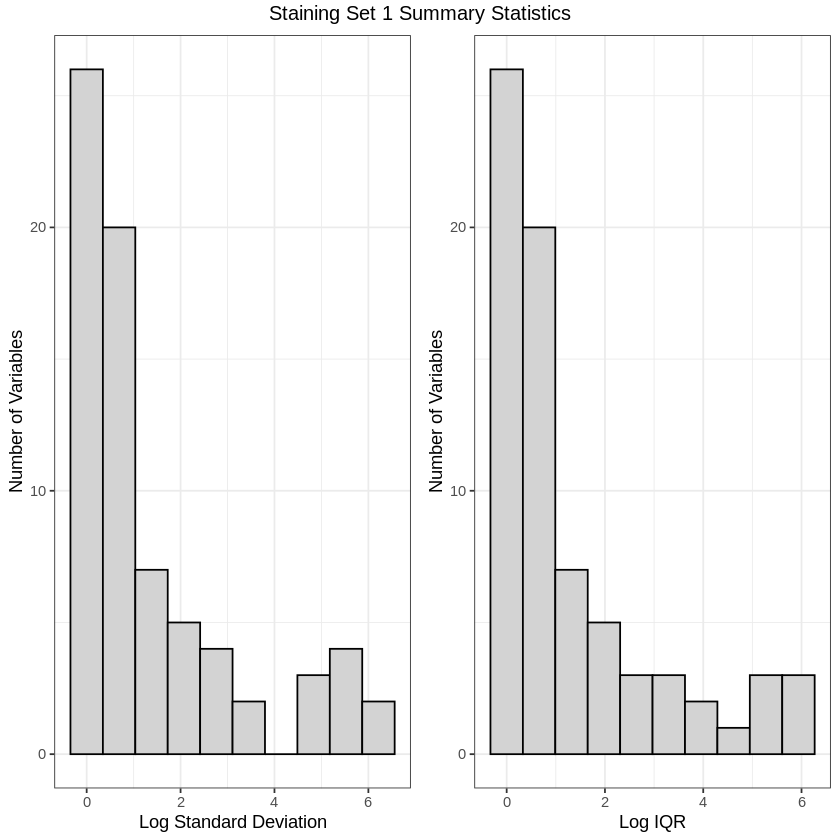

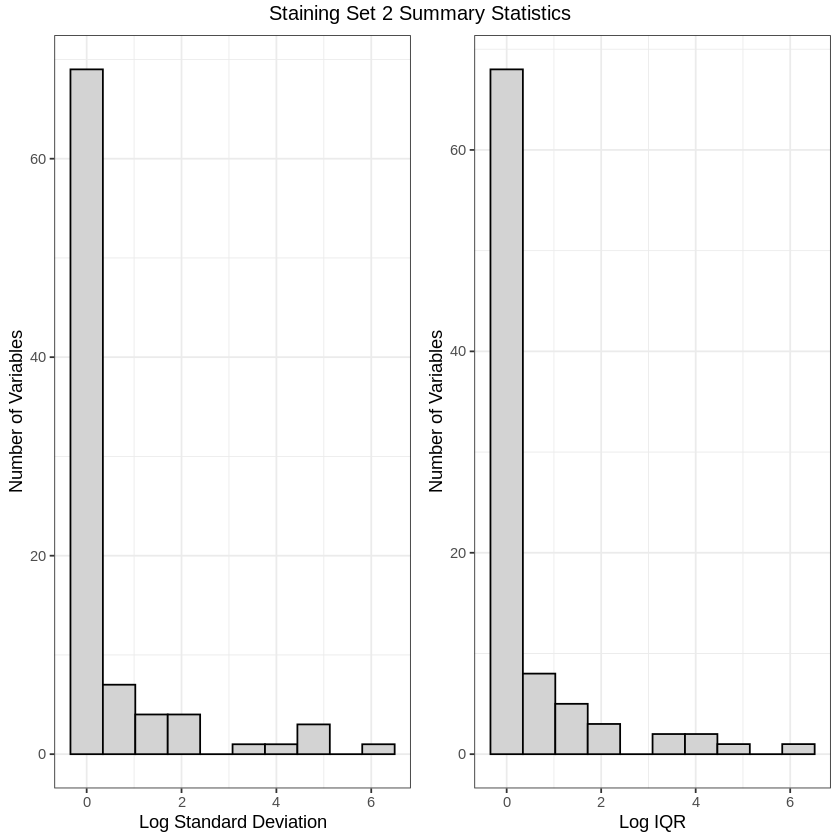

# A tibble: 15 × 4
   ss_num col                                                          sd    iqr
    <int> <chr>                                                     <dbl>  <dbl>
 1      1 Nuclei_CP_Intensity_IntegratedIntensity_Dapi           1638923. 8.66e5
 2      1 Cytoplasm_CP_Intensity_IntegratedIntensity_CellMask     787860. 4.82e5
 3      1 Cells_CP_Intensity_IntegratedIntensity_Actin            545831. 4.44e5
 4      1 Cytoplasm_CP_Intensity_IntegratedIntensity_Dapi         541628. 3.16e5
 5      1 Cytoplasm_CP_Intensity_IntegratedIntensity_Actin        342647. 1.77e5
 6      2 Nuclei_CP_Intensity_IntegratedIntensity_Dapi           1418742. 1.50e6
 7      2 Nuclei_CP_Intensity_IntegratedIntensity_EdU              71194. 2.28e4
 8      2 Nuclei_CP_Intensity_IntegratedIntensity_EdU_SE           54050. 2.82e4
 9      2 Nuclei_CP_Intensity_IntegratedIntensity_Fibrillarin      33193. 3.56e4
10      2 Nuclei_CP_Intensity_IntegratedIntensity_Fibrillarin_SE    6252. 3.14e3
11      3

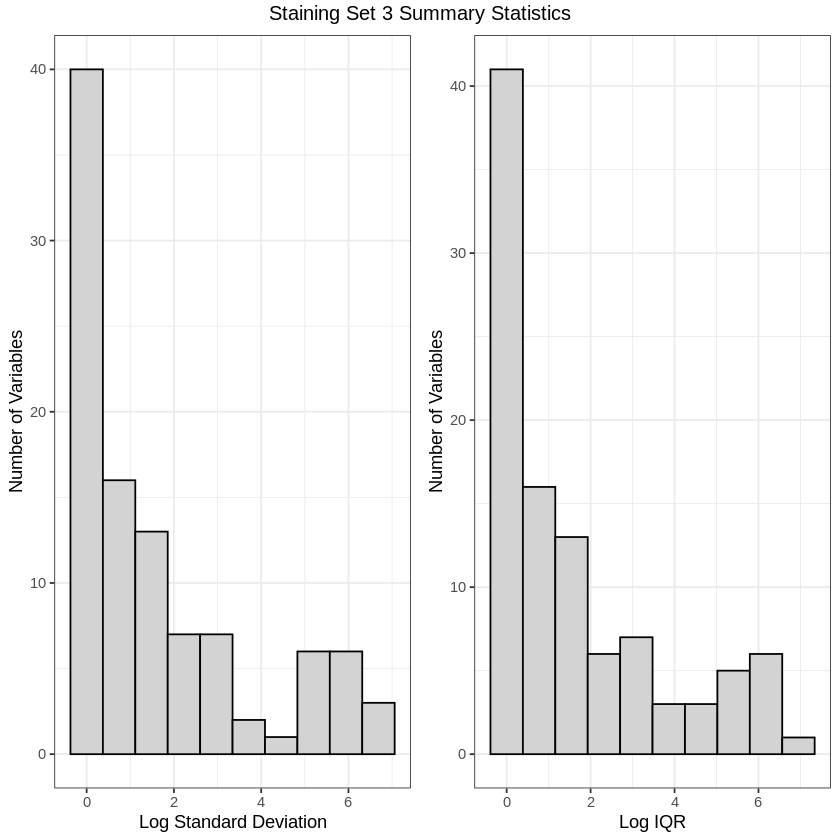

In [60]:
all_summary_stats <- all_data2 %>%
  mutate(
    summary_stats = map(data, calc_summary_stats),
    title = map_chr(
      ss_num, ~ str_interp("Staining Set ${.x} Summary Statistics")
    ),
    summary_stats_plot = map2(summary_stats, title, make_summary_stats_plot)
  )

with(all_summary_stats, walk(summary_stats_plot, grid.arrange))

all_summary_stats %>%
  mutate(
    summary_stats = map(
      summary_stats, ~ slice(arrange(.x, desc(sd)), n = 1:5)
    )
  ) %>%
  select(ss_num, summary_stats) %>%
  unnest(summary_stats) %>%
  print(n = 15)

rm(all_summary_stats)

<!-- The histograms below show the log-transformed standard deviations and IQRs of the AreaShape variables. We again see that the variables differ in scale substantially.  -->

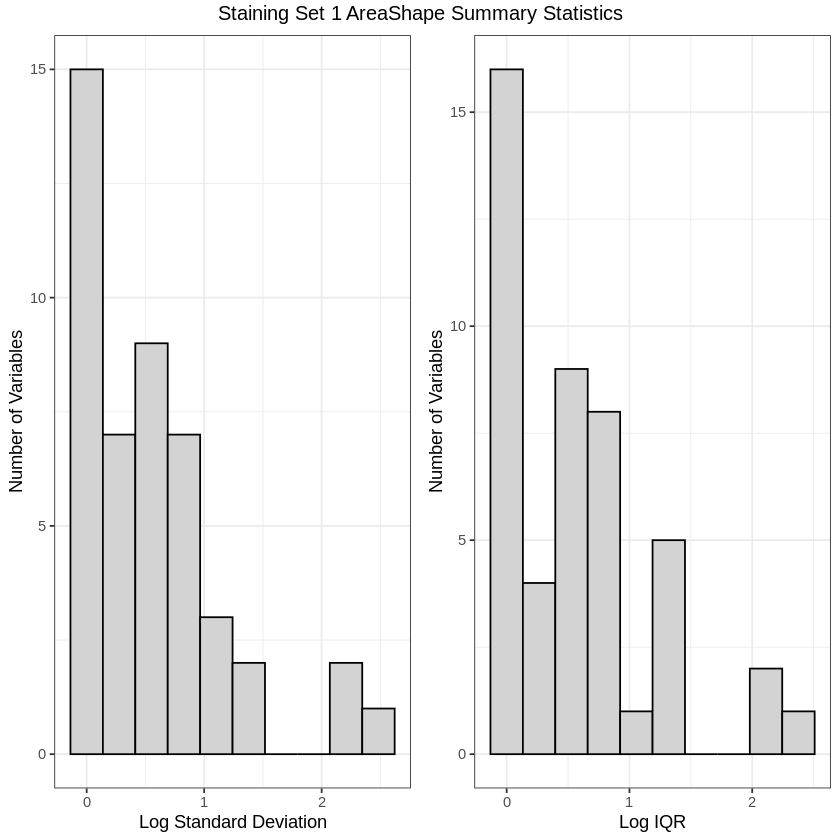

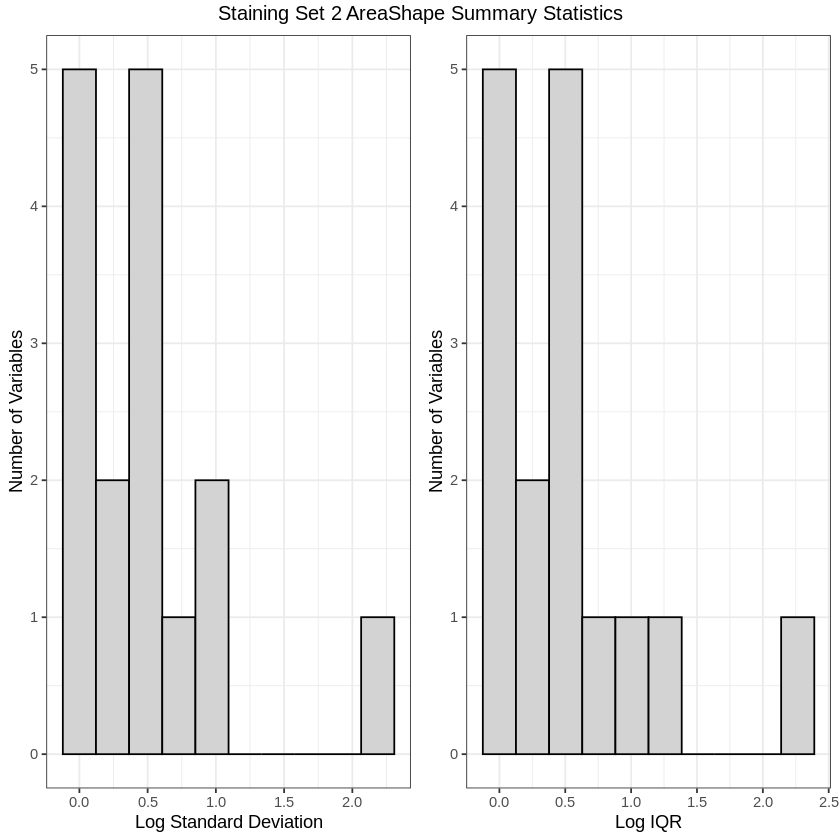

# A tibble: 15 × 4
   ss_num col                                      sd    iqr
    <int> <chr>                                 <dbl>  <dbl>
 1      1 Cells_CP_AreaShape_Area              303.   237   
 2      1 Cytoplasm_CP_AreaShape_Area          220.   114.  
 3      1 Nuclei_CP_AreaShape_Area             132.   153   
 4      1 Cytoplasm_CP_AreaShape_Perimeter      24.7   24.9 
 5      1 Cells_CP_AreaShape_Perimeter          18.6   16   
 6      2 Nuclei_CP_AreaShape_Area             152.   183   
 7      2 Nuclei_CP_AreaShape_Orientation       10.6   12.9 
 8      2 Nuclei_CP_AreaShape_Perimeter          7.65   8.60
 9      2 Nuclei_PA_AreaShape_Neighbors          3.63   4   
10      2 Nuclei_CP_AreaShape_MajorAxisLength    2.72   3.20
11      3 Cells_CP_AreaShape_Area             1158.   937   
12      3 Cytoplasm_CP_AreaShape_Area         1036.   783   
13      3 Nuclei_CP_AreaShape_Area             279.   348   
14      3 Cytoplasm_CP_AreaShape_Perimeter     135.   118.  
15   

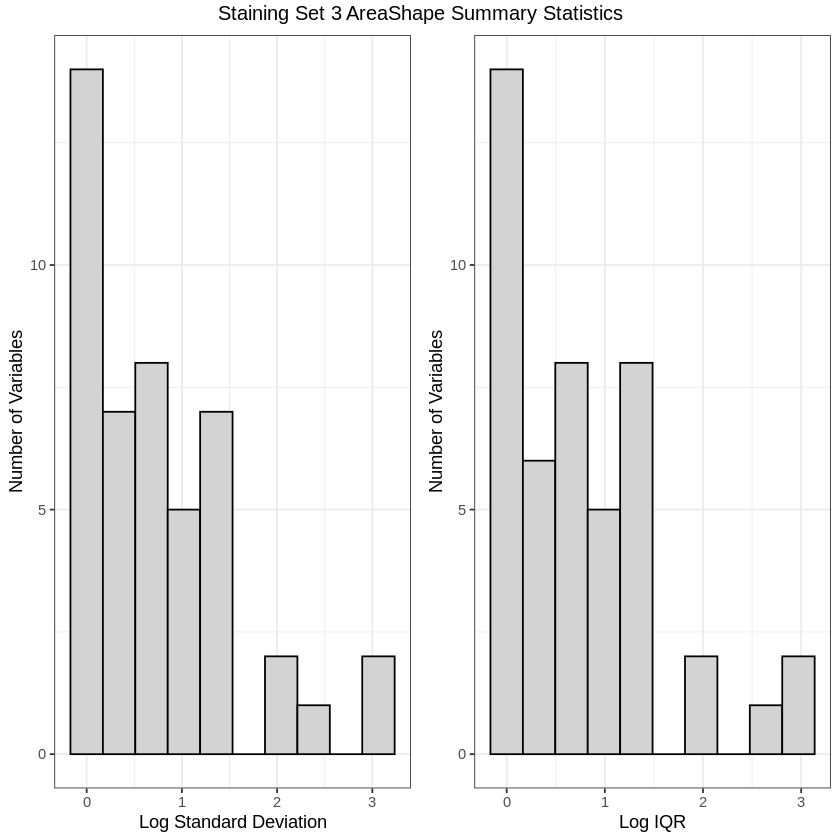

In [61]:
all_summary_stats <- all_data2 %>%
  mutate(
    summary_stats = map(data, calc_summary_stats, pattern = "AreaShape"),
    title = map_chr(
      ss_num, ~ str_interp("Staining Set ${.x} AreaShape Summary Statistics")
    ),
    summary_stats_plot = map2(summary_stats, title, make_summary_stats_plot)
  )

with(all_summary_stats, walk(summary_stats_plot, grid.arrange))

all_summary_stats %>%
  mutate(
    summary_stats = map(
      summary_stats, ~ slice(arrange(.x, desc(sd)), n = 1:5)
    )
  ) %>%
  select(ss_num, summary_stats) %>%
  unnest(summary_stats) %>%
  print(n = 15)

rm(all_summary_stats)

## PCA

<!-- Define functions for running PCA and plotting the results of PCA. -->

In [62]:
run_pca <- function(data, pattern = ".*") {
  data %>%
    select(
      where(is.numeric) &
        where(~ !any(is.na(.x))) &
        where(~ n_distinct(.x) > 1) &
        !any_of(numeric_id_cols) &
        matches(pattern)
    ) %>%
    prcomp(scale. = TRUE)
}

make_prop_var_explained_plot <- function(pca_results, title) {
  plot <- pca_results %>%
    `$`("sdev") %>%
    `^`(2) %>%
    {cumsum(.) / sum(.)} %>%
    enframe(name = "num_pcs", value = "prop_var_explained") %>%
    ggplot(aes(num_pcs, prop_var_explained)) +
    geom_point() +
    geom_line() +
    geom_hline(linetype = "dashed", yintercept = 0.95) +
    labs(
      x = "Number of PCs", y = "Proportion of Variation Explained",
      title = title
    ) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
  brks <- layer_scales(plot)$y$get_breaks()
  plot + scale_y_continuous(breaks = c(brks, 0.95))
}

make_first_pc_loadings_plot <- function(pca_results, title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, "PC1") %>%
    enframe(name = "col", value = "loading") %>%
    ggplot(aes(loading)) +
    geom_histogram(color = "black", fill = "lightgray", binwidth = 0.01) +
    labs(x = "PC1 Loading", y = "Number of Variables", title = title) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot_no_pattern <- function(pca_results, title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, c("PC1", "PC2")) %>%
    as_tibble(rownames = "col") %>%
    rename(loading1 = PC1, loading2 = PC2) %>%
    ggplot(aes(loading1, loading2)) +
    geom_point() +
    labs(x = "PC1 Loading", y = "PC2 Loading", title = title) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot_pattern <- function(pca_results,
                                                    pattern,
                                                    title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, c("PC1", "PC2")) %>%
    as_tibble(rownames = "col") %>%
    rename(loading1 = PC1, loading2 = PC2) %>%
    mutate(
      col_parts = str_split(col, "_"),
      subset1 = map_chr(col_parts, 1),
      subset2 = map_chr(col_parts, 3)
    ) %>%
    select(!col_parts) %>%
    select(where(~ !all(str_detect(.x, pattern)))) %>%
    rename_with(str_remove, starts_with("subset"), pattern = "\\d$") %>%
    ggplot(aes(loading1, loading2, color = subset)) +
    geom_point() +
    labs(
      x = "PC1 Loading", y = "PC2 Loading",
      color = "Subset",
      title = title
    ) +
    theme_bw() +
    theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot <- function(pca_results, pattern = ".*", title) {
  if (pattern == ".*") {
    make_first_2_pcs_loadings_plot_no_pattern(pca_results, title)
  } else {
    make_first_2_pcs_loadings_plot_pattern(pca_results, pattern, title)
  }
}

make_pca_results_plot <- function(pca_results, pattern = ".*", title) {
  panel1 <- make_prop_var_explained_plot(pca_results, title = NULL)
  panel2 <- make_first_pc_loadings_plot(pca_results, title = NULL)
  panel3 <- make_first_2_pcs_loadings_plot(pca_results, pattern, title = NULL)
  
  legend <- get_legend(panel3)
  if (is.null(legend)) {
    return(arrangeGrob(panel1, panel2, panel3, nrow = 1, top = title))
  }
  panel3 <- panel3 + theme(legend.position = "none")
  plot_grid(
    arrangeGrob(panel1, panel2, panel3, nrow = 1, top = title),
    legend,
    ncol = 1,
    rel_heights = c(9, 1)
  )
}

make_pca_results_plots <- function(pattern = ".*", ss_nums = 1:3) {
  if (pattern == ".*") {
    title_template <- "PCA Results for Staining Set ${.x}, All Variables"
  } else {
    title_template <- 
      "PCA Results for Staining Set ${.x}, ${pattern} Variables Only"
  }
  all_data2 %>%
    filter(ss_num %in% ss_nums) %>%
    mutate(
      pca_results = map(data, run_pca, pattern = pattern),
      title = map_chr(ss_num, ~ str_interp(title_template)),
      pca_results_plot = map2(
        pca_results, title, make_pca_results_plot, pattern = pattern
      )
    )
}

We first ran PCA using all non-trivial numeric variables. We considered a numeric variable to be non-trivial if it wasn't an ID variable, didn't have any missing values, and had more than one unique value. Each variable was centered and scaled beforehand. Because of the differences we observed between staining sets, we carried out PCA separately for the different staining sets. The plots below show the results of PCA for all non-trivial numeric variables. In the left-hand panels, we see that the first 20-30 principal components (PCs) capture around 95\% of the variation for each staining set. The middle panels show the loadings for the first PC. Every PC can be expressed as a linear combination of the original variables; the coefficients in the linear combination are called loadings. Ideally, most loadings would be close to zero, and only a few would have non-trivial magnitudes. Then, interpretation of the PC in terms of the original variables would be simple. However, this was not the case; many of the loadings were non-trivial. The right-hand panels plot the PC2 loading versus the PC1 loading for each variable. It would be interesting if the variables lay in clusters, but this isn't the case below.

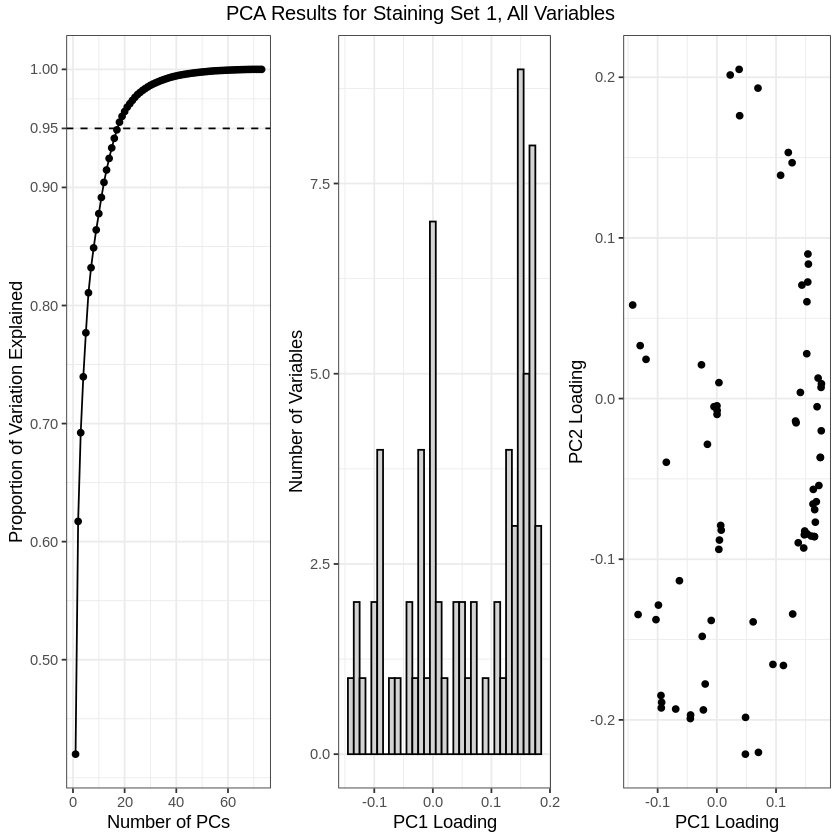

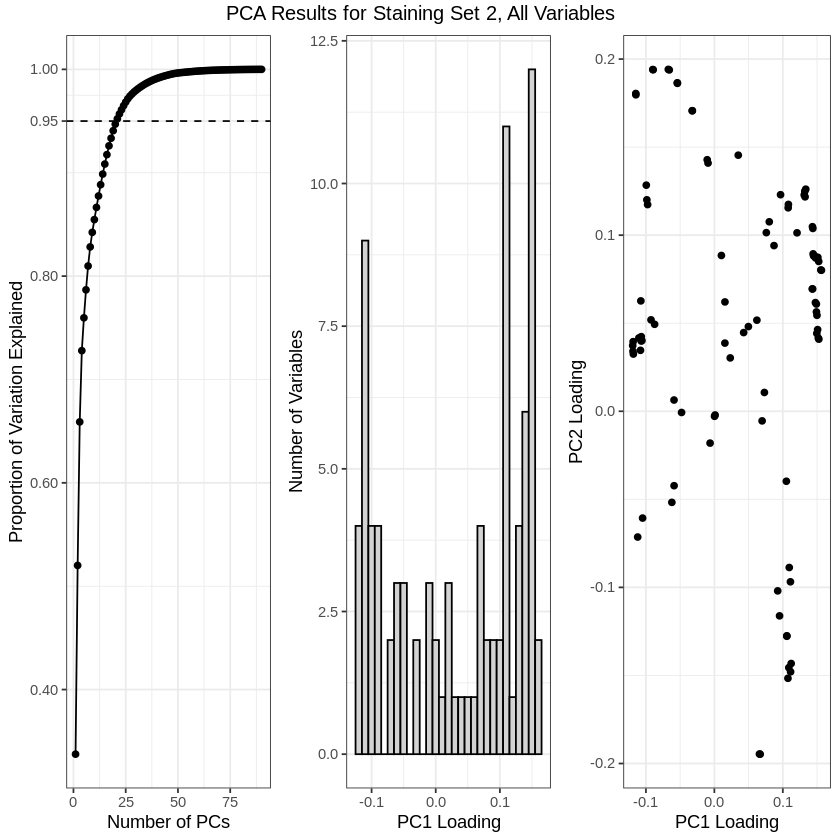

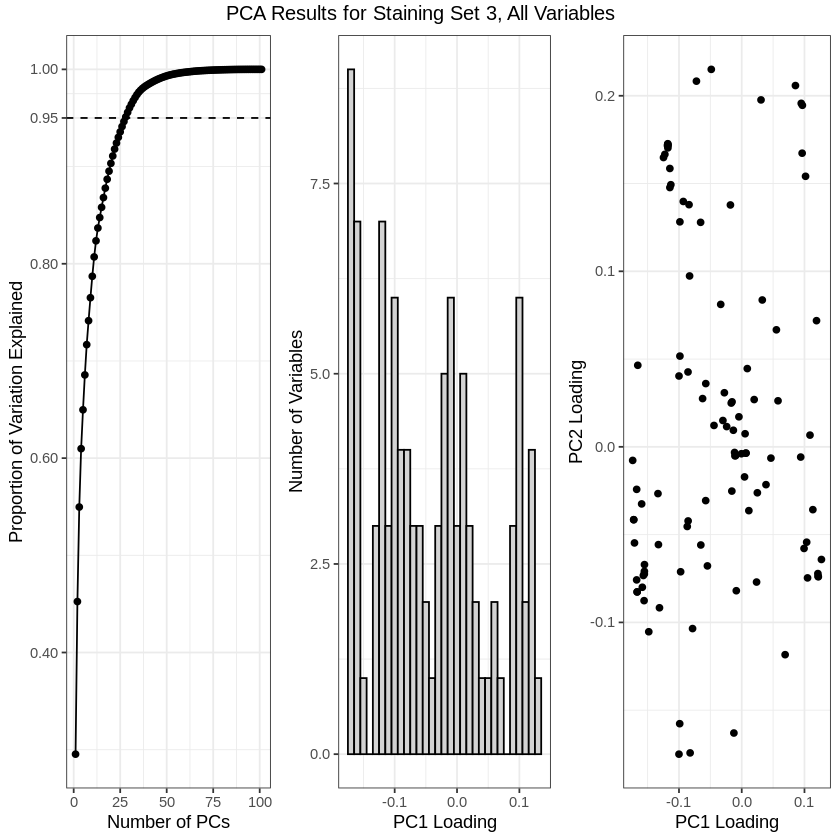

In [63]:
make_pca_results_plots() %>%
  with(walk(pca_results_plot, grid.arrange))

<!-- Define a function that counts non-trivial numeric columns whose names match a pattern. -->

In [64]:
count_cols <- function(data, pattern) {
  data %>%
    select(
      where(is.numeric) &
        where(~ !any(is.na(.x))) &
        where(~ n_distinct(.x) > 1) &
        !any_of(numeric_id_cols) &
        matches(pattern)
    ) %>%
    ncol()
}

### PCA by Variable Class

For each class of columns, count columns by staining set. Some classes don't appear in all staining sets. For others, the counts differ substantially across staining sets.

In [65]:
all_data2 %>%
  mutate(
    num_areashape_cols = map_int(data, count_cols, pattern = "AreaShape"),
    num_intensity_cols = map_int(data, count_cols, pattern = "Intensity"),
    num_cycle_cols = map_int(data, count_cols, pattern = "Cycle"),
    num_gated_cols = map_int(data, count_cols, pattern = "Gated"),
    num_texture_cols = map_int(data, count_cols, pattern = "Texture")
  ) %>%
  select(!c(StainingSet, ss_num, data)) %>%
  print(width = 100)

# A tibble: 3 × 5
  num_areashape_cols num_intensity_cols num_cycle_cols num_gated_cols
               <int>              <int>          <int>          <int>
1                 46                 18              3              0
2                 16                 10              3              3
3                 46                 34              3             12
  num_texture_cols
             <int>
1                0
2               52
3                0


Looking only at the AreaShape variables, fewer than ten PCs account for over 95\% of the variation. In particular, for staining set 2, just four PCs account for that percentage of the variation. Plots of the PC1 and PC2 loadings don't seem to reveal anything.

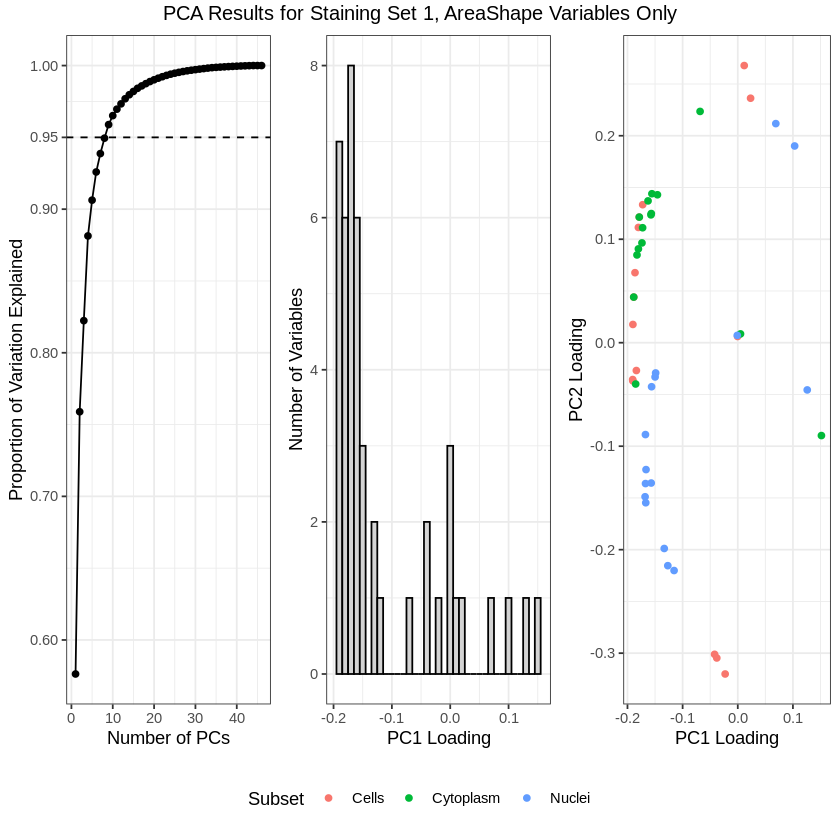

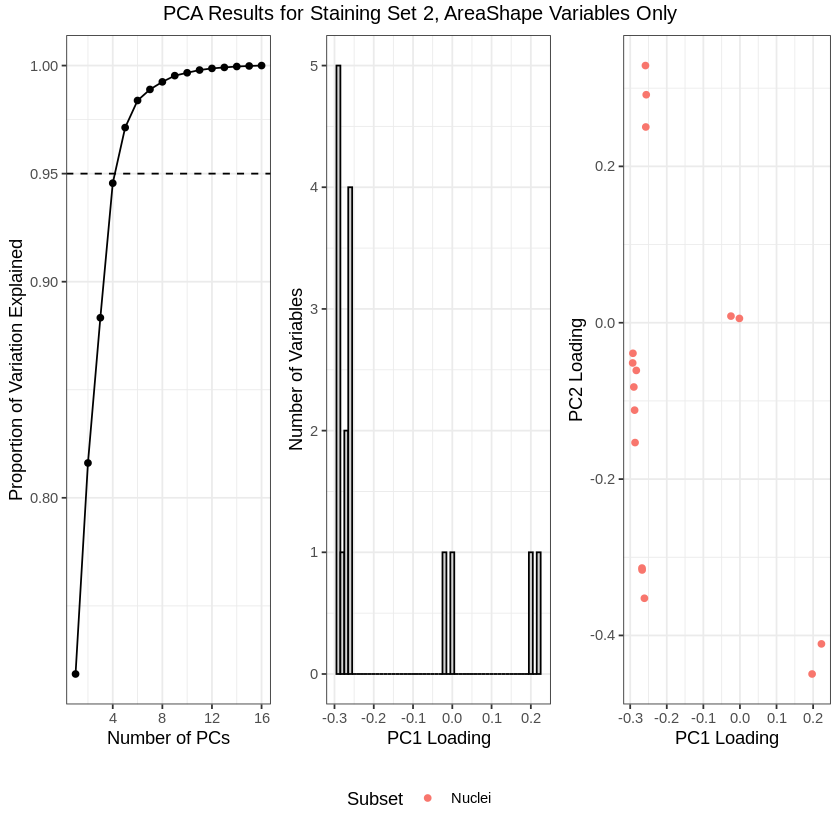

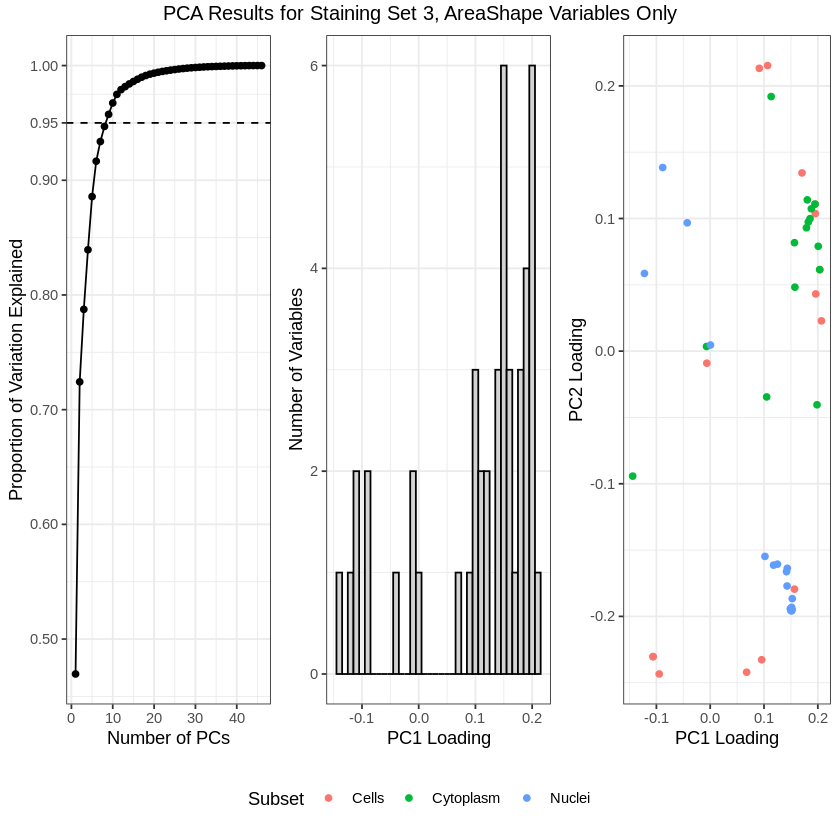

In [66]:
make_pca_results_plots(pattern = "AreaShape") %>%
  with(walk(pca_results_plot, grid.arrange))

We next consider the Intensity variables. For staining sets 1 and 2, around five PCs capture 95\% of the variation. However, for staining set 3, 12-13 PCs are needed. Plots of the PC1 and PC2 loadings don't seem to reveal anything.

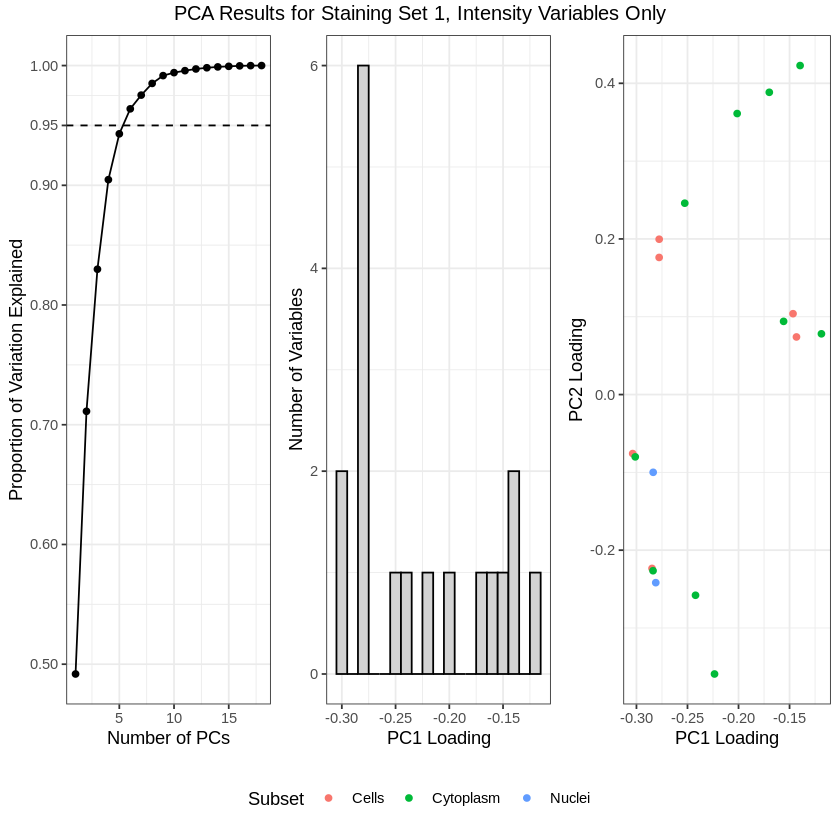

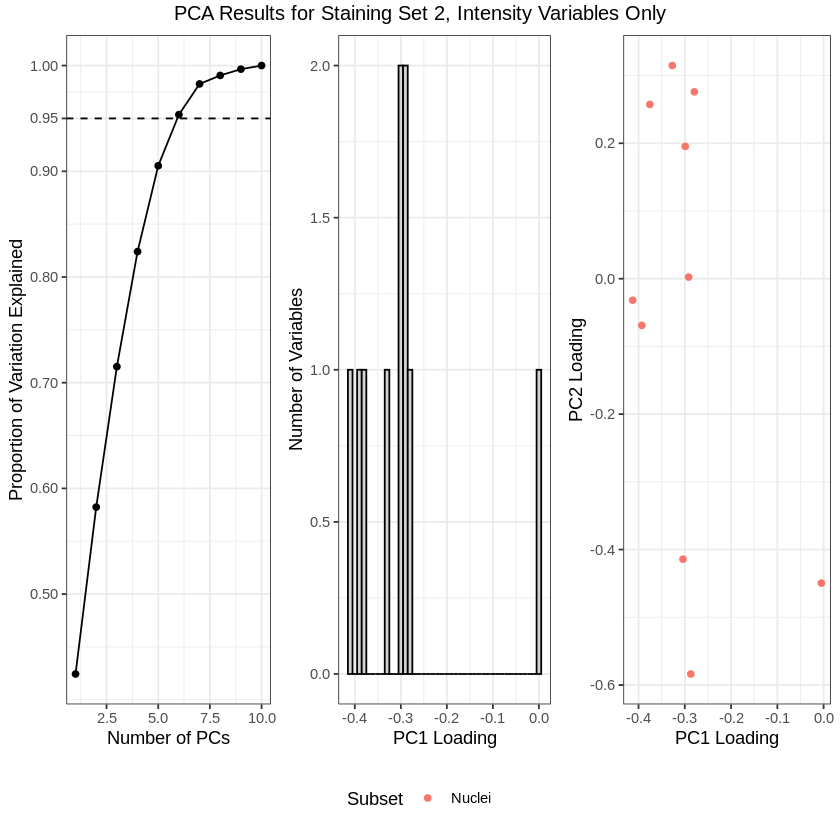

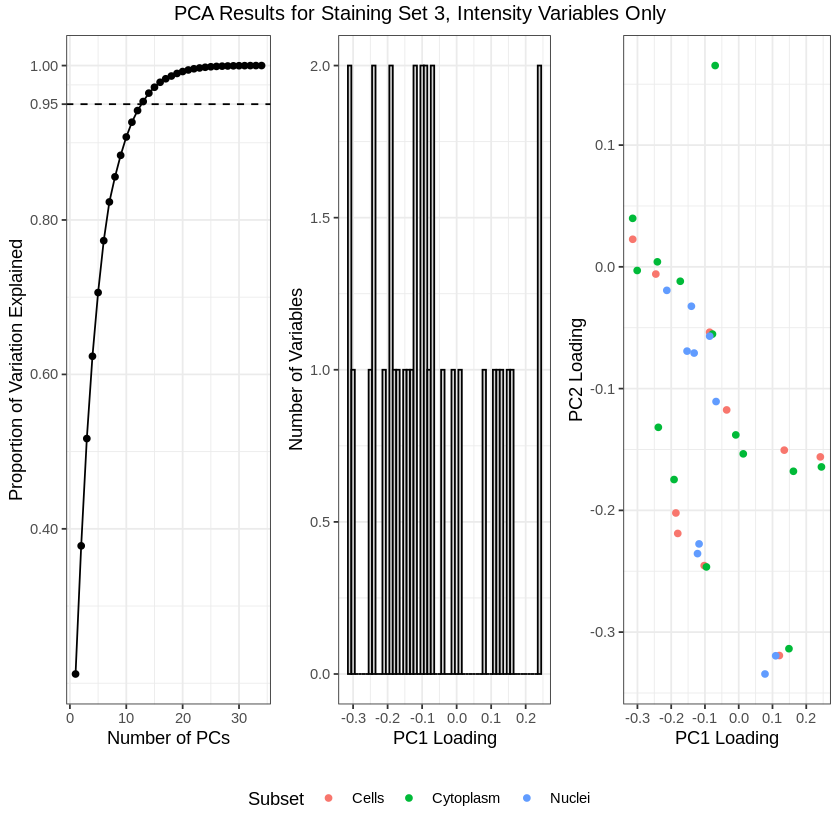

In [67]:
make_pca_results_plots(pattern = "Intensity") %>%
  with(walk(pca_results_plot, grid.arrange))

<!-- For the Cycle variables, for each staining set, the top two PCs account for all of the variation.  Plots of the PC1 and PC2 loadings don't seem to reveal anything. -->

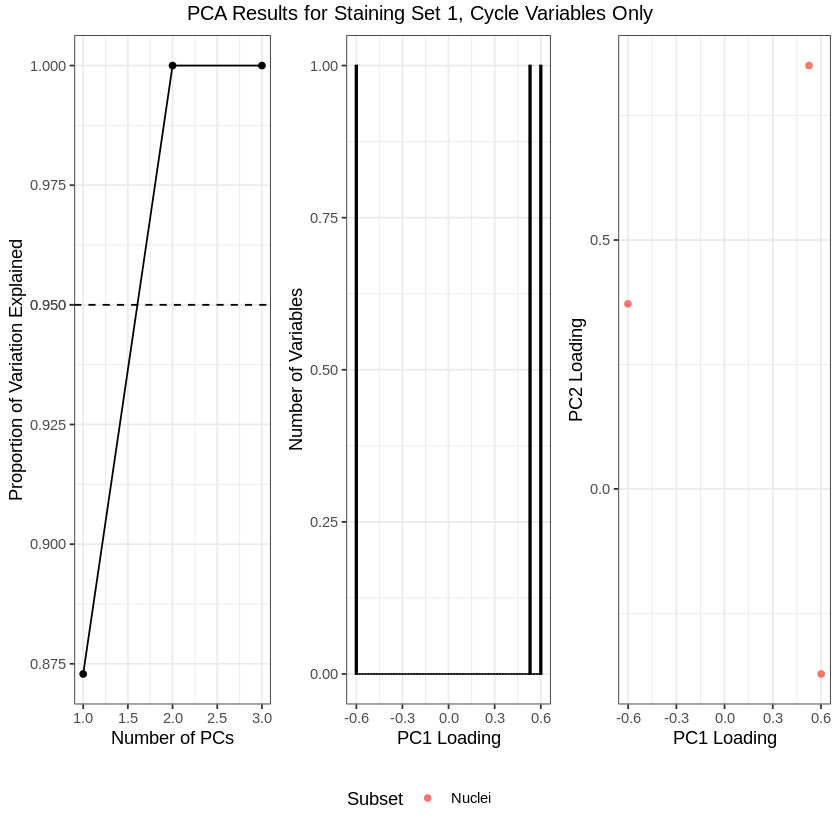

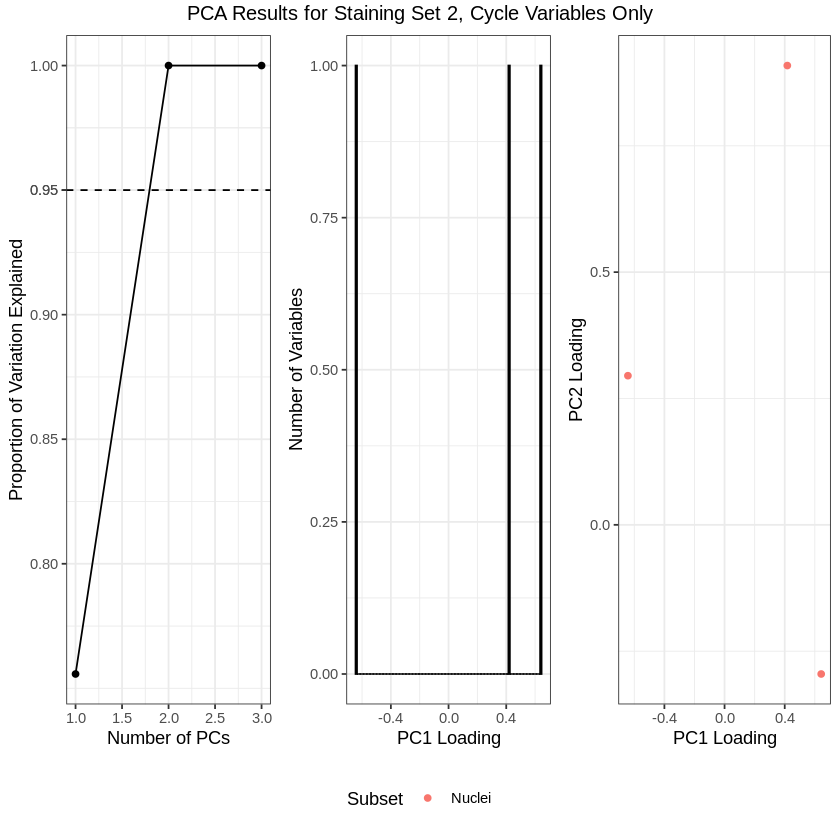

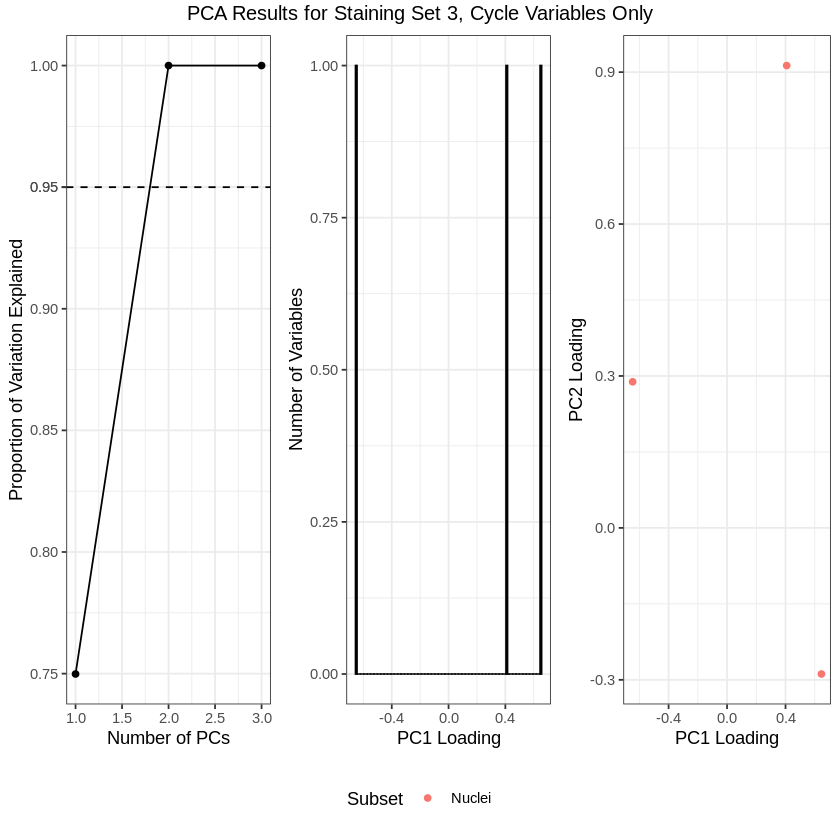

In [68]:
make_pca_results_plots(pattern = "Cycle") %>%
  with(walk(pca_results_plot, grid.arrange))

<!-- We next consider the Gated variables, which weren't measured for staining set 1. For staining set 2, all PCs are needed to capture 95\% of the variation. For staining set 3, five PCs are needed. Plots of the PC1 and PC2 loadings don't seem to reveal anything. -->

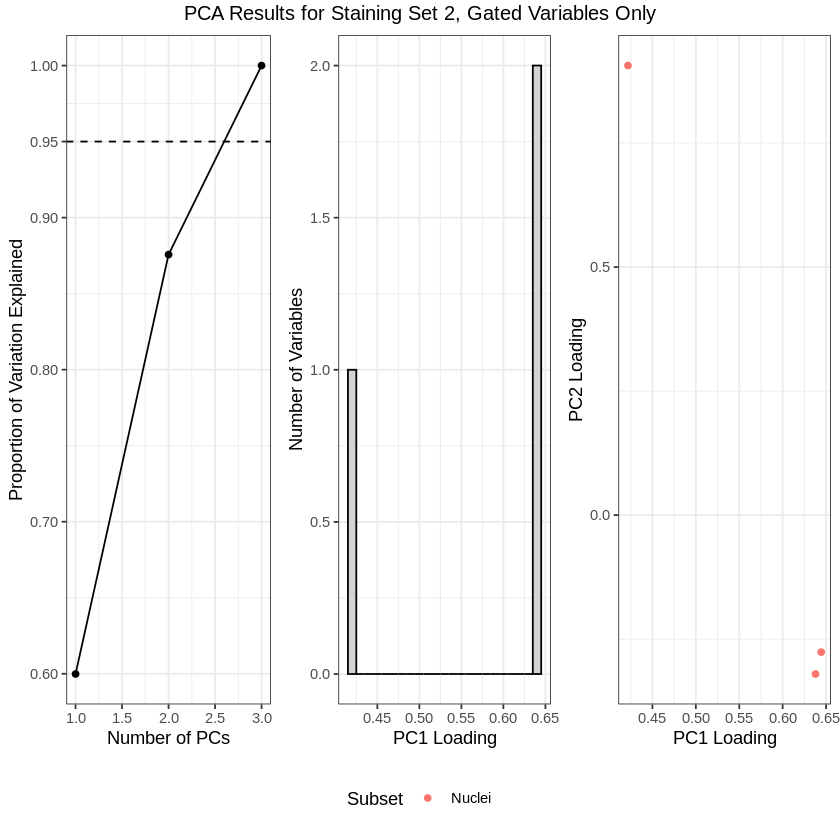

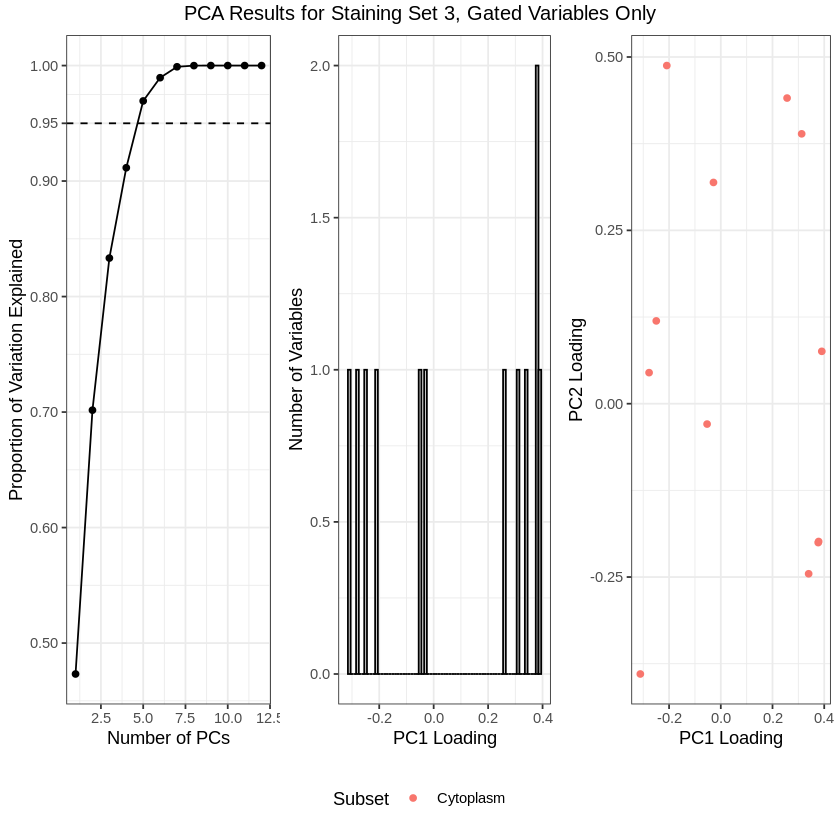

In [69]:
make_pca_results_plots(pattern = "Gated", ss_nums = c(2, 3)) %>%
  with(walk(pca_results_plot, grid.arrange))

The Texture variables were only measured for staining set 2. Six PCs account for 95\% of the variation. The plot of the PC1 and PC2 loadings seems to suggest that the variables can be partitioned into three clusters.

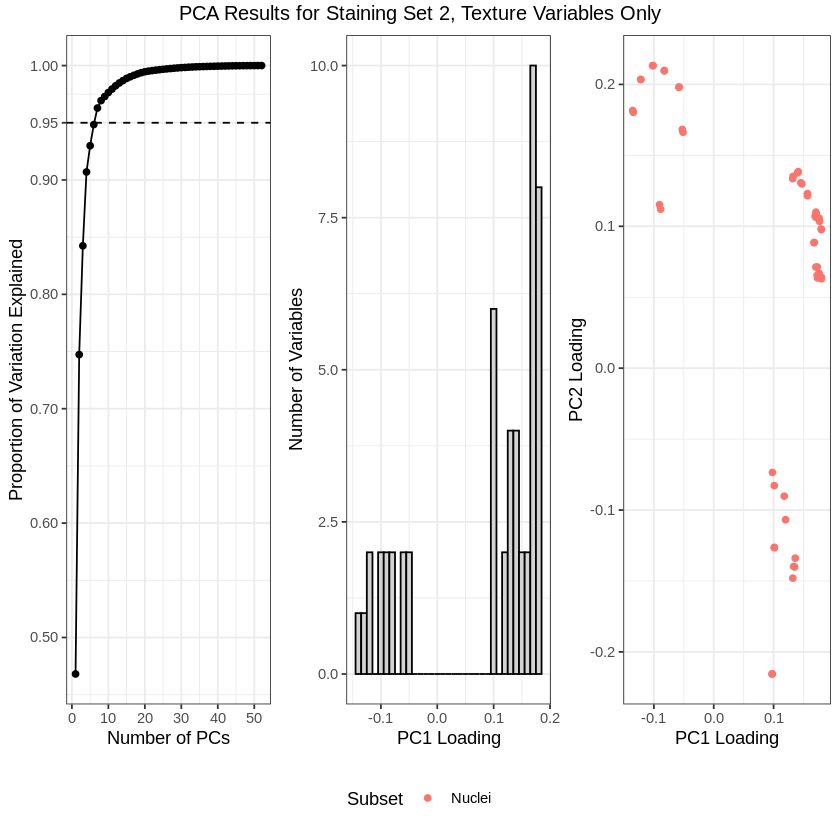

In [70]:
make_pca_results_plots(pattern = "Texture", ss_nums = 2) %>%
  with(walk(pca_results_plot, grid.arrange))

### PCA by Cell Part

For each cell part, count columns by staining set. As before, some classes don't appear in all staining sets. For others, the counts differ substantially across staining sets.

In [71]:
all_data2 %>%
  mutate(
    num_cells_cols = map_int(data, count_cols, pattern = "Cells"),
    num_cytoplasm_cols = map_int(data, count_cols, pattern = "Cytoplasm"),
    num_nuclei_cols = map_int(data, count_cols, pattern = "Nuclei")
  ) %>%
  select(!c(StainingSet, ss_num, data))

num_cells_cols,num_cytoplasm_cols,num_nuclei_cols
<int>,<int>,<int>
21,25,21
0,0,84
25,41,29


Looking at the Cells variables, for staining set 1, the first seven PCs account for 95\% of the variation. For staining set 3, the number is nine. Plots of the PC1 and PC2 loadings don't seem to reveal anything.

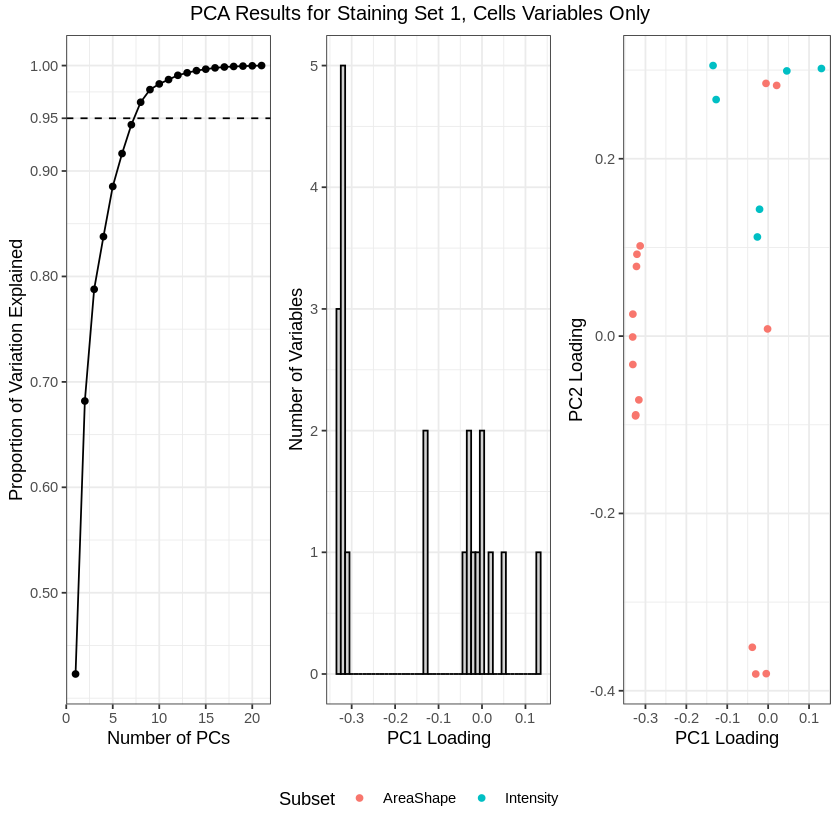

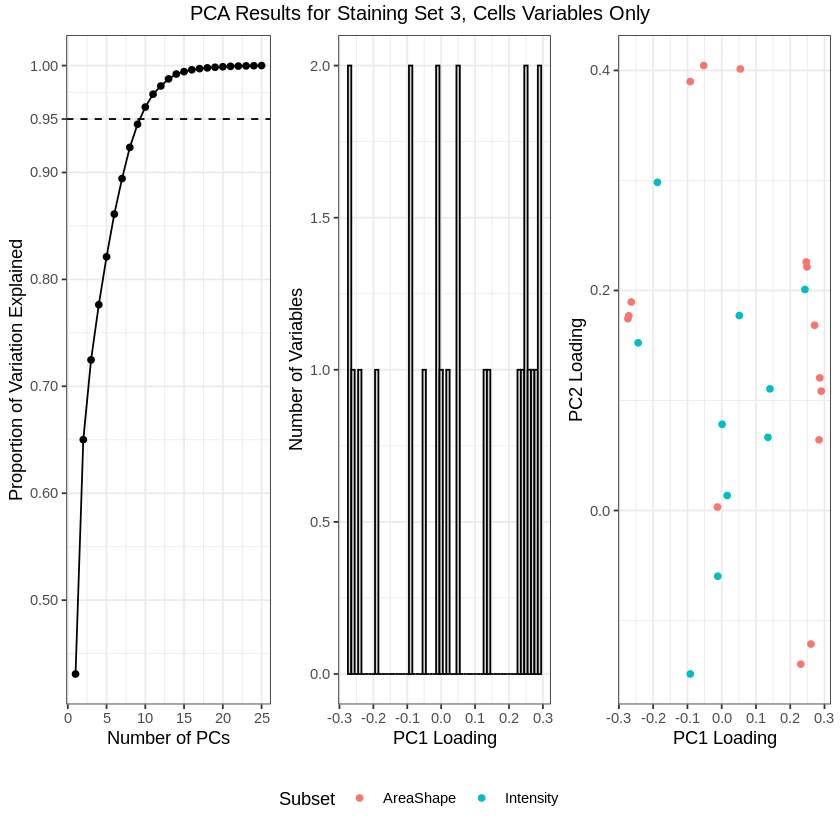

In [72]:
make_pca_results_plots(pattern = "Cells", ss_nums = c(1, 3)) %>%
  with(walk(pca_results_plot, grid.arrange))

Looking at the Cytoplasm variables, for staining set 1, the first eight PCs account for 95\% of the variation. For staining set 3, the number is 15. Plots of the PC1 and PC2 loadings don't seem to reveal anything.

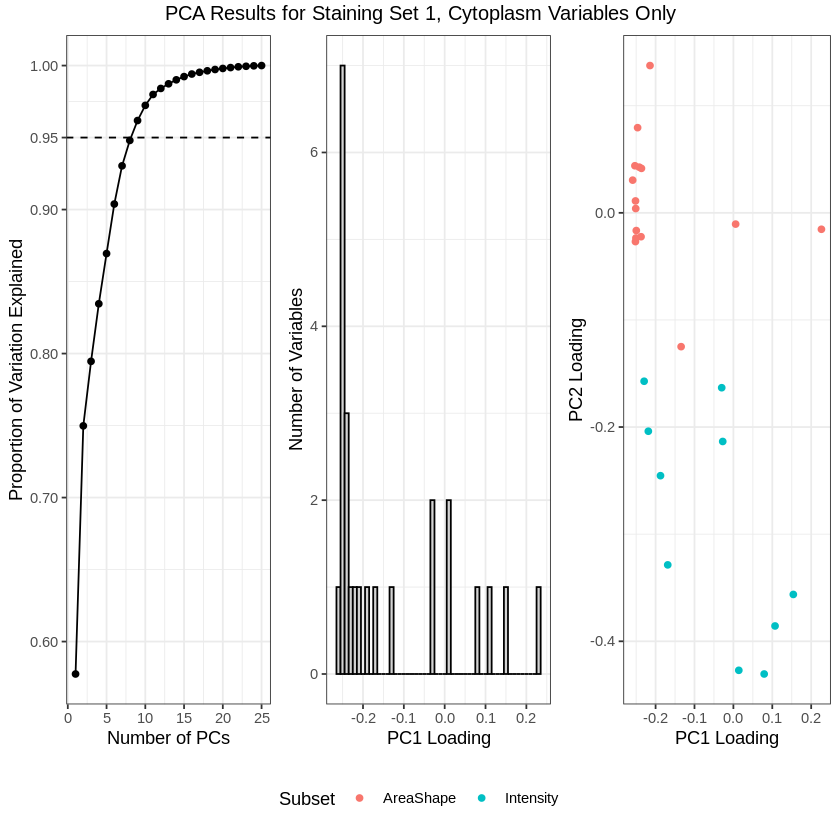

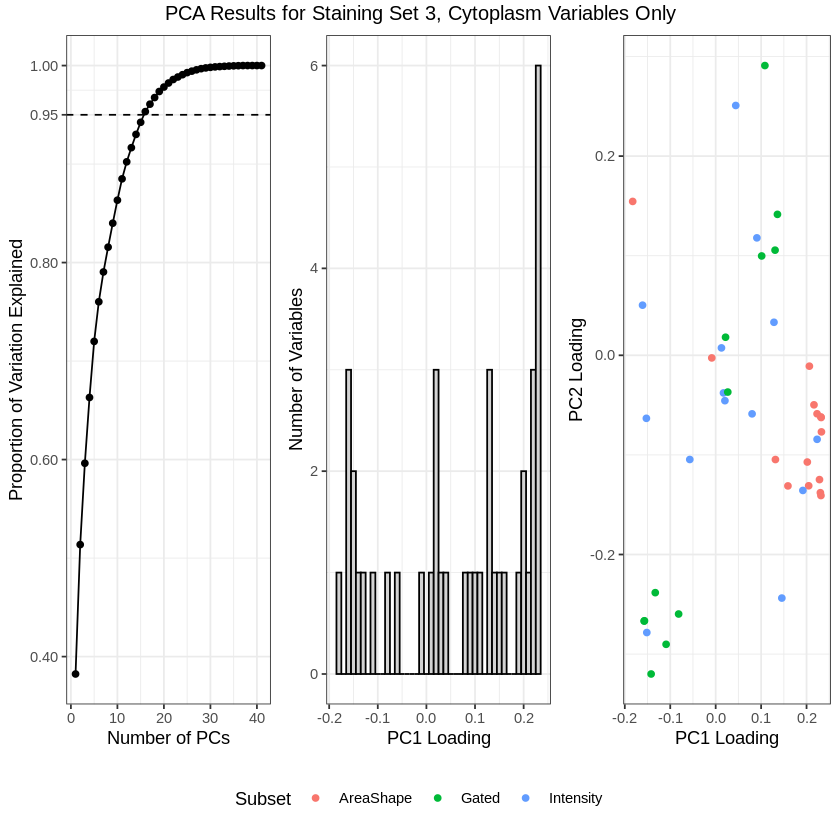

In [73]:
make_pca_results_plots(pattern = "Cytoplasm", ss_nums = c(1, 3)) %>%
  with(walk(pca_results_plot, grid.arrange))

Looking at the Nuclei variables, for staining set 1, the first seven PCs account for 95\% of the variation. For staining set 2, the number is around 17. For staining set 3, the number is 11. Plots of the PC1 and PC2 loadings don't seem to reveal anything.

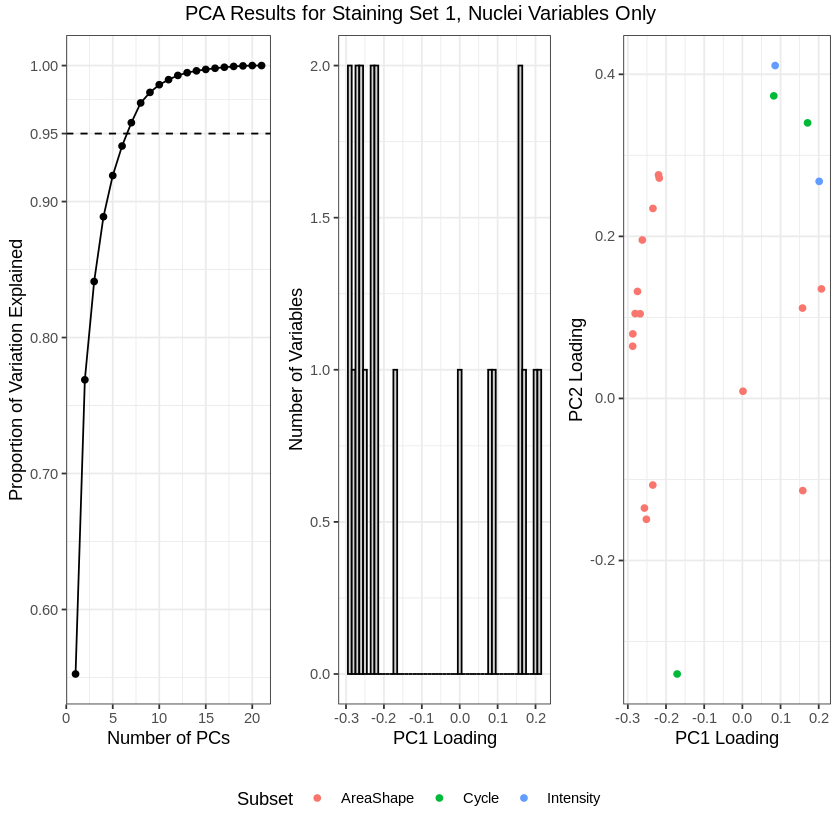

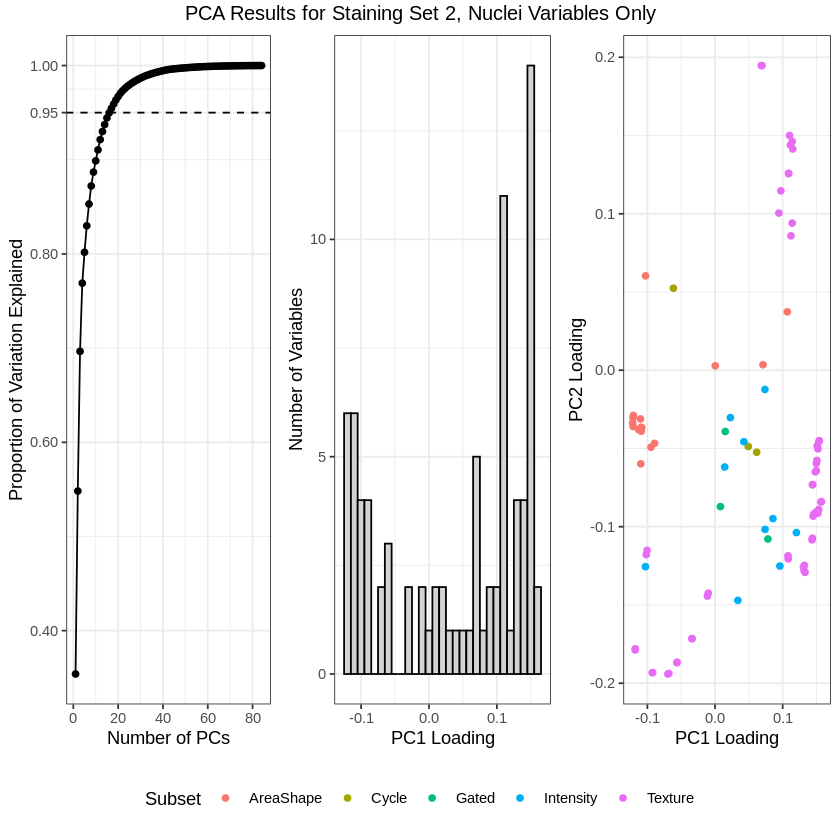

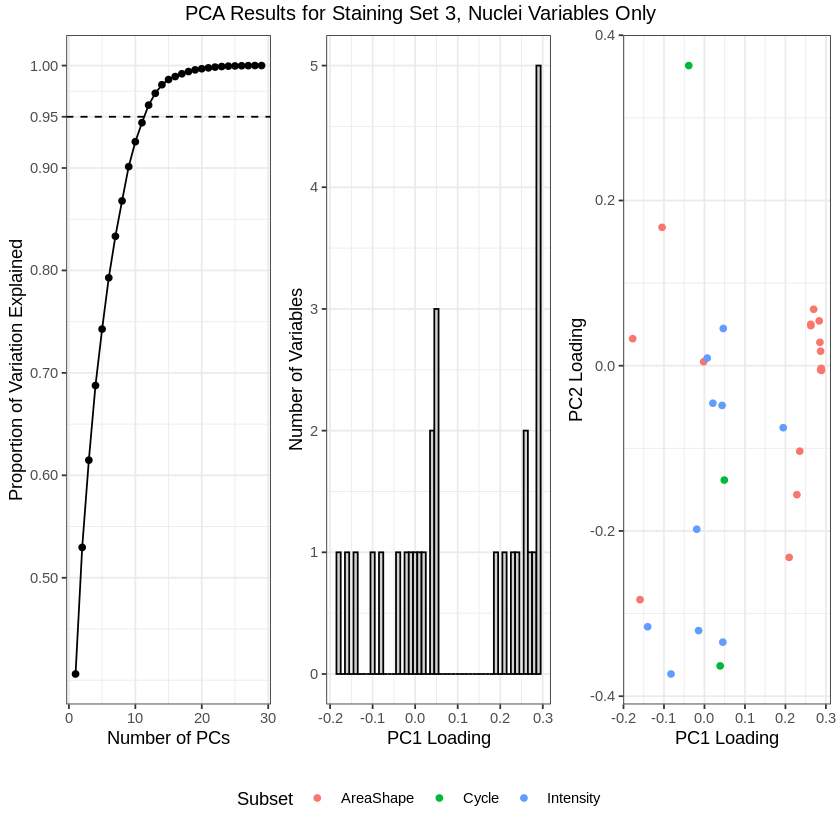

In [74]:
make_pca_results_plots(pattern = "Nuclei") %>%
  with(walk(pca_results_plot, grid.arrange))

# Outlier Detection

In [77]:
make_outlyingness_plot <- function(plate_num,
                                   plate_data,
                                   plot_type = c(
                                     "outlyingness", "flag"
                                   )) {
  if (plot_type == "outlyingness") {
    col <- as.name("outlyingness")
    fill_lab <- "Outlyingness"
  } else {
    col <- as.name("is_outlier")
    fill_lab <- "Is Outlier?"
  }
  
  plate_data %>%
    ggplot(aes(ArrayColumn, ArrayRow, fill = !!col)) +
    facet_wrap(vars(Well), nrow = 2) +
    geom_tile() +
    labs(
      x = NULL, y = NULL,
      fill = fill_lab,
      title = str_interp("Plate ${plate_num}")
    ) +
    theme_bw() +
    theme(
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      plot.title = element_text(hjust = 0.5),
      strip.text = element_blank()
    )
}

make_outlyingness_plots <- function(ss_num,
                                    data,
                                    pattern,
                                    invariance_type = c(
                                      "Affine", "Rotation", "Shift"
                                    ),
                                    plot_type = c(
                                      "outlyingness", "flag"
                                    )
                                    ) {
  pca_results <- run_pca(data, pattern)
  lambdas <- pca_results$sdev^2
  num_pcs <- lambdas %>%
    {cumsum(.) / sum(.)} %>%
    `>=`(0.95) %>%
    which() %>%
    min()
  
  outlyingness_obj <- pca_results %>%
    `$`("x") %>%
    `[`(, seq_len(num_pcs)) %>%
    adjOutl(options = list(type = invariance_type))

  plots <- data %>%
    select(plate_num, Well, ArrayColumn, ArrayRow) %>%
    add_column(
      outlyingness = outlyingness_obj$outlyingnessX,
      is_outlier = !outlyingness_obj$flagX
    ) %>%
    nest(plate_data = !plate_num) %>%
    mutate(
      outlyingness_plot = map2(
        plate_num, plate_data,
        make_outlyingness_plot,
        plot_type = plot_type
      )
    ) %>%
    pull()

  if (pattern == ".*") {
    title <- str_interp("Staining Set ${ss_num}, All Variables")
  } else {
    title <- str_interp(
      "Staining Set ${ss_num}, ${pattern} Variables Only"
    )
  }
  title <- textGrob(title, gp = gpar(fontsize = 20))
  legend <- get_legend(plots[[1]] + theme(legend.position = "bottom"))
  plots %>%
    map(function(plot) plot + theme(legend.position = "none")) %>%
    plot_grid(plotlist = ., nrow = 2, ncol = 4) %>%
    plot_grid(title, ., legend, ncol = 1, rel_heights = c(1, 9, 1))
}

We sought to identify replicates that could be considered outliers with respect to their staining sets. We performed outlier detection by calculating a skew-adjusted version of a measure of outlyingness called the Stahel-Donoho outlyingness (SDO) for each replicate. In the univariate case, the ordinary SDO of an observation $x_i$ is
\[
\text{SDO}(x_i) := \frac{|x_i - \text{med}_j x_j|}{\text{med}_k |x_k - \text{med}_j x_j|}.
\]
In the multivariate case, the SDO of $\boldsymbol{x}_i$ is
\[
\text{SDO}(\boldsymbol{x}_i) := \sup_{\boldsymbol{u} \in \mathbb{R}^d} \frac{|\boldsymbol{x}_i^T \boldsymbol{u} - \text{med}_j \boldsymbol{x}_j^T \boldsymbol{u}|}{\text{med}_k |\boldsymbol{x}_k^T \boldsymbol{u} - \text{med}_j \boldsymbol{x}_j^T \boldsymbol{u}|}.
\]
The measure we used is a robust version of the ordinary multivariate SDO appropriate for skewed data. Since not all directions could be used in the computations, a subset of directions was used that was chosen in a random fashion. As in the dimensionality reduction section, we performed outlier detection for various subsets of the numeric variables.

The plots below show the distribution of the outliers across the wells for each staining set and each variable subset. In most wells, there are few outliers, and they're scattered seemingly randomly across the well. However, in some wells, there are large concentrations of outliers. The reasons for these concentrations are unclear; further investigation is necessary to determine them.

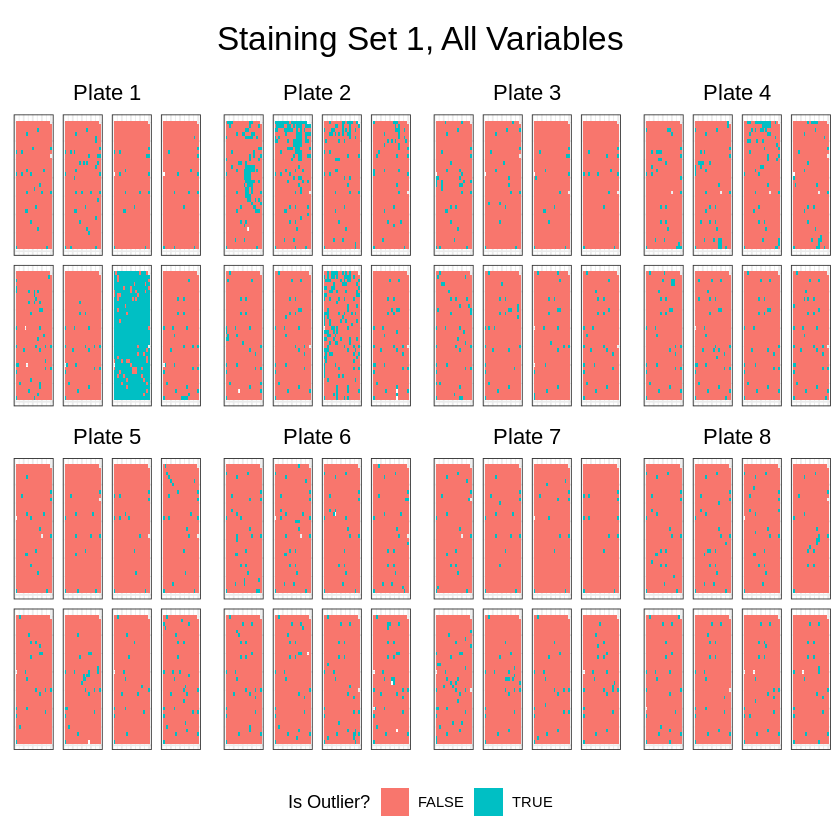

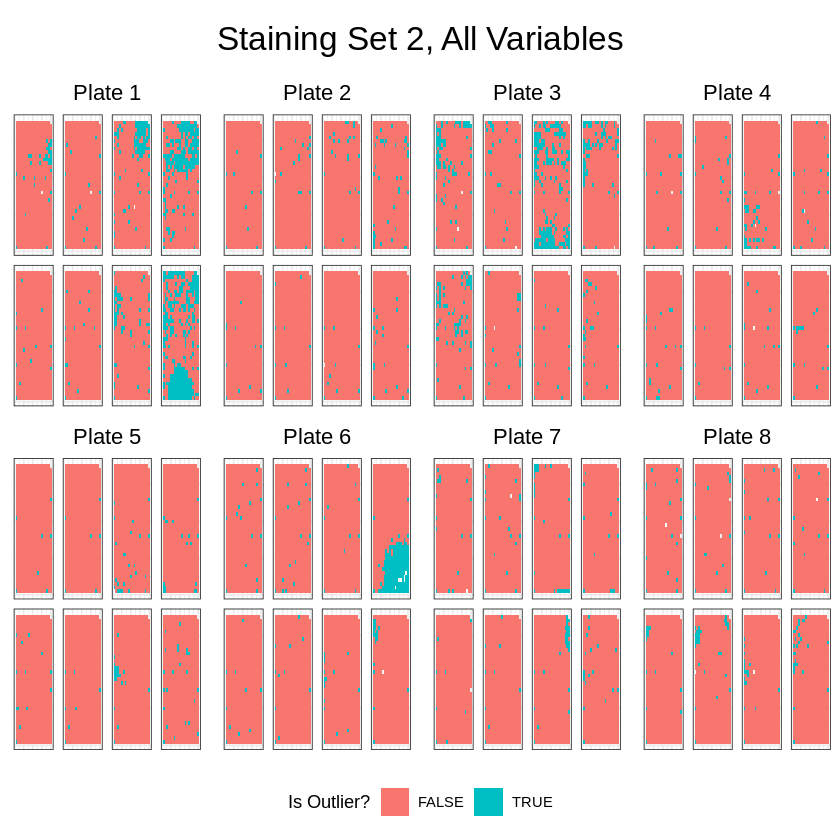

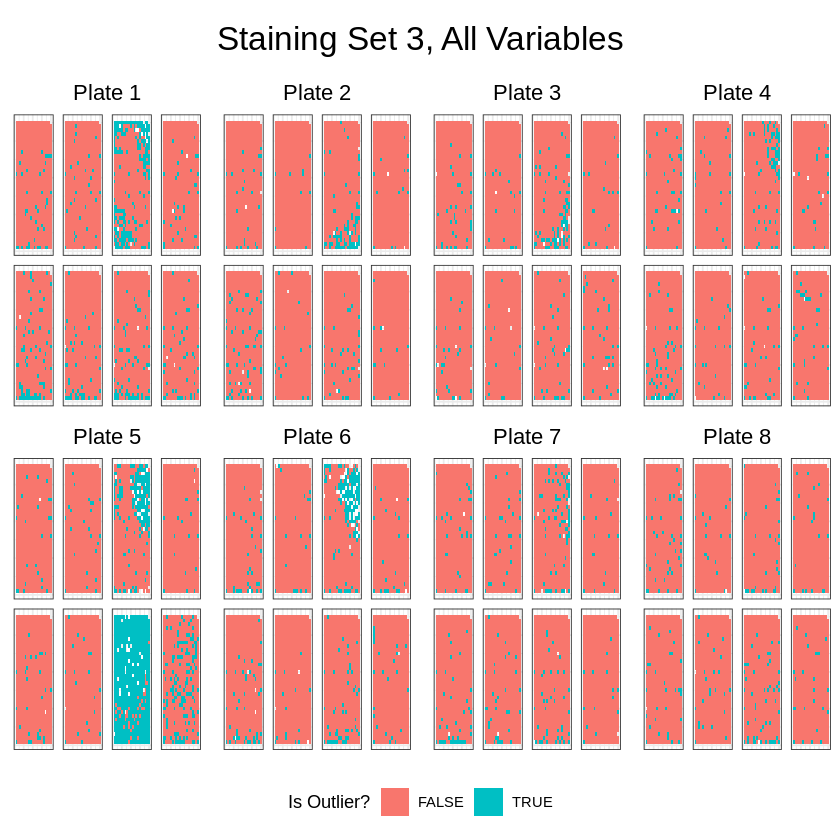

In [78]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = ".*", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

### Outlier Detection by Variable Class

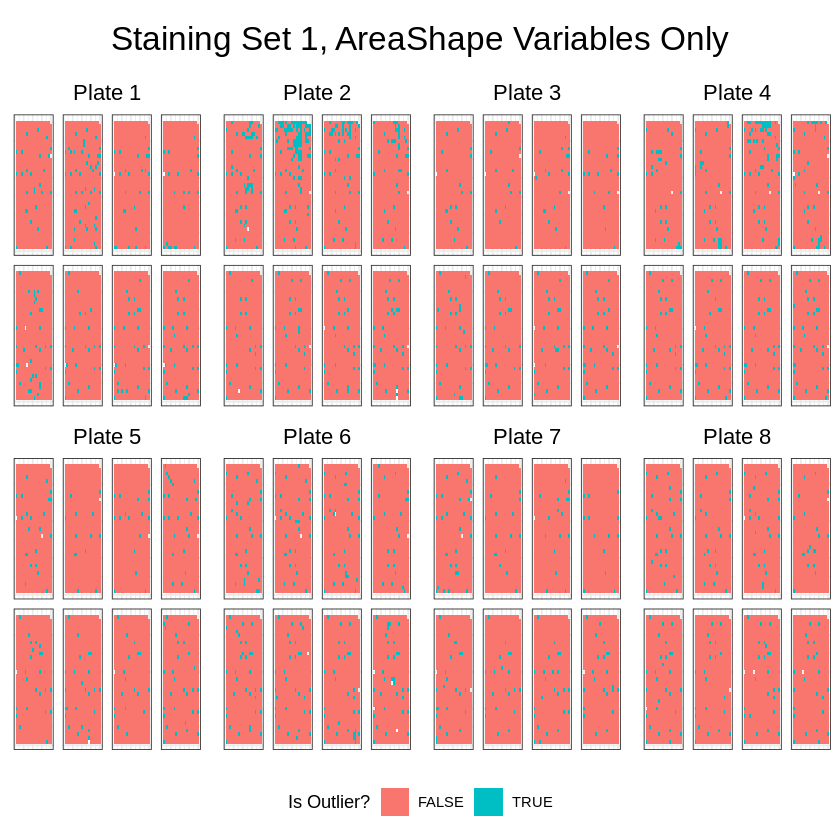

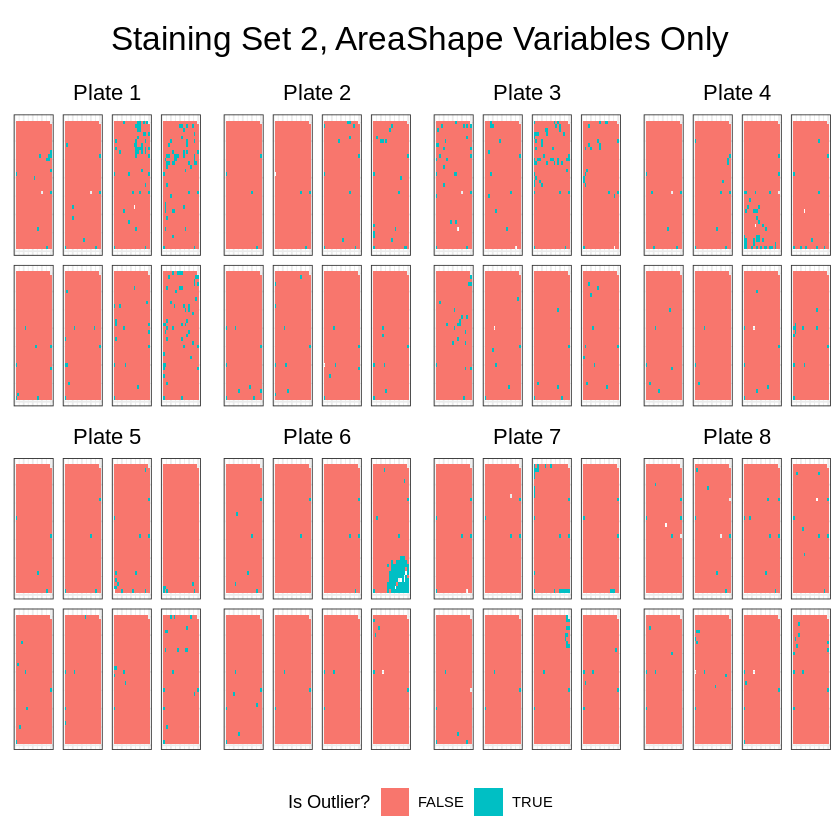

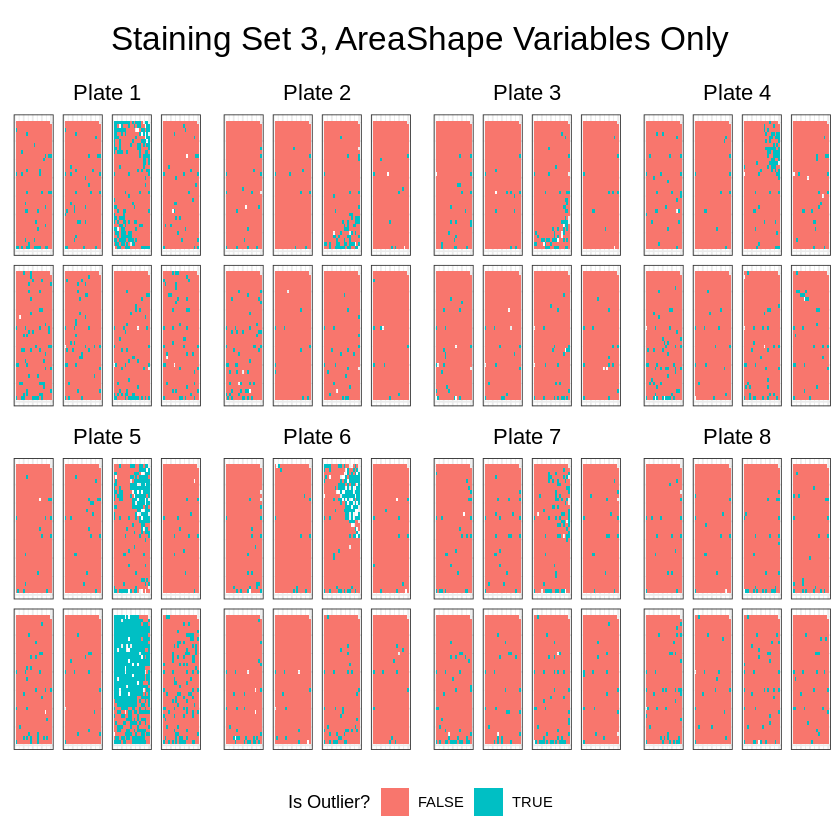

In [79]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "AreaShape", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

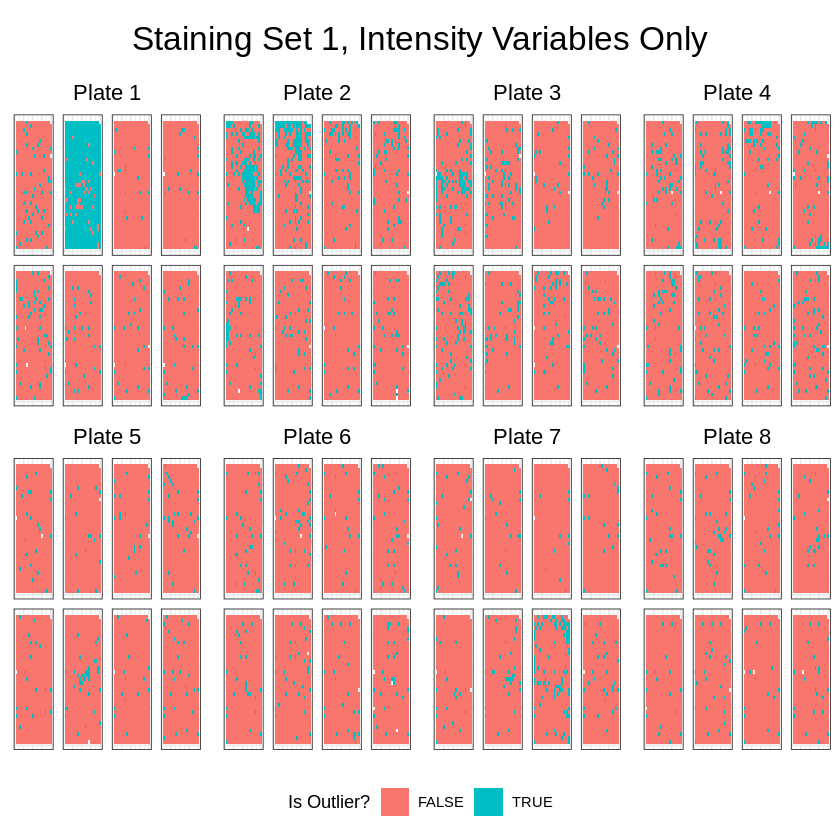

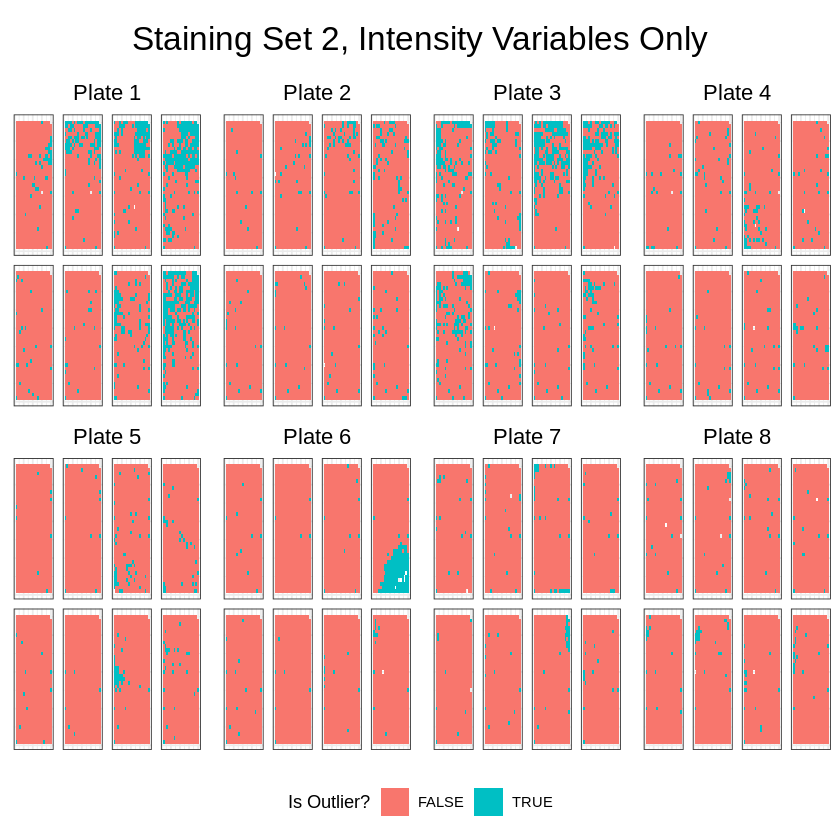

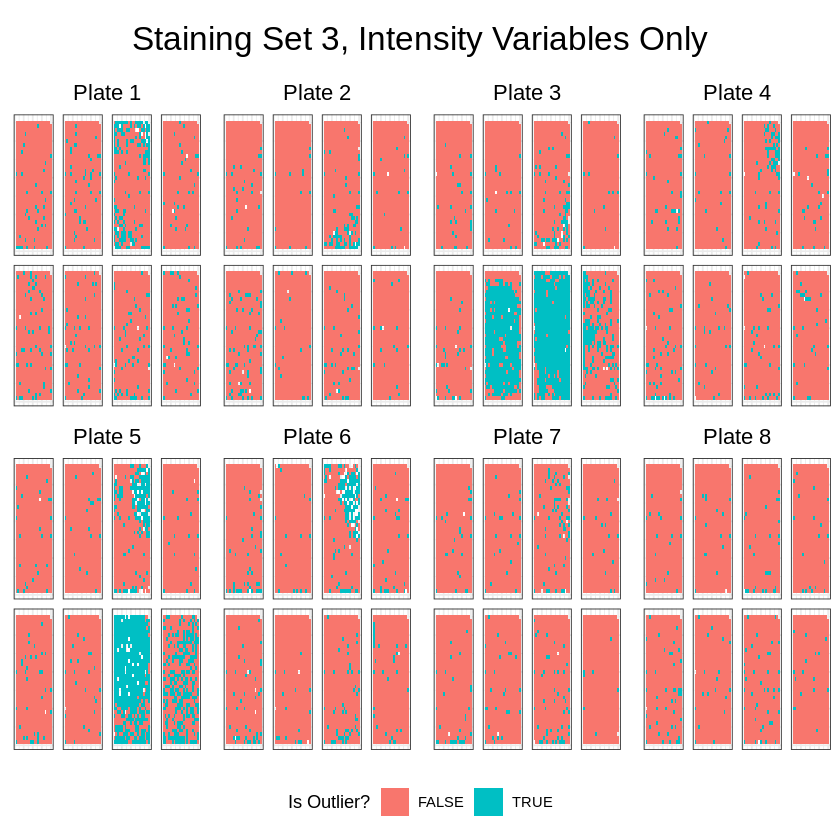

In [80]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Intensity", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

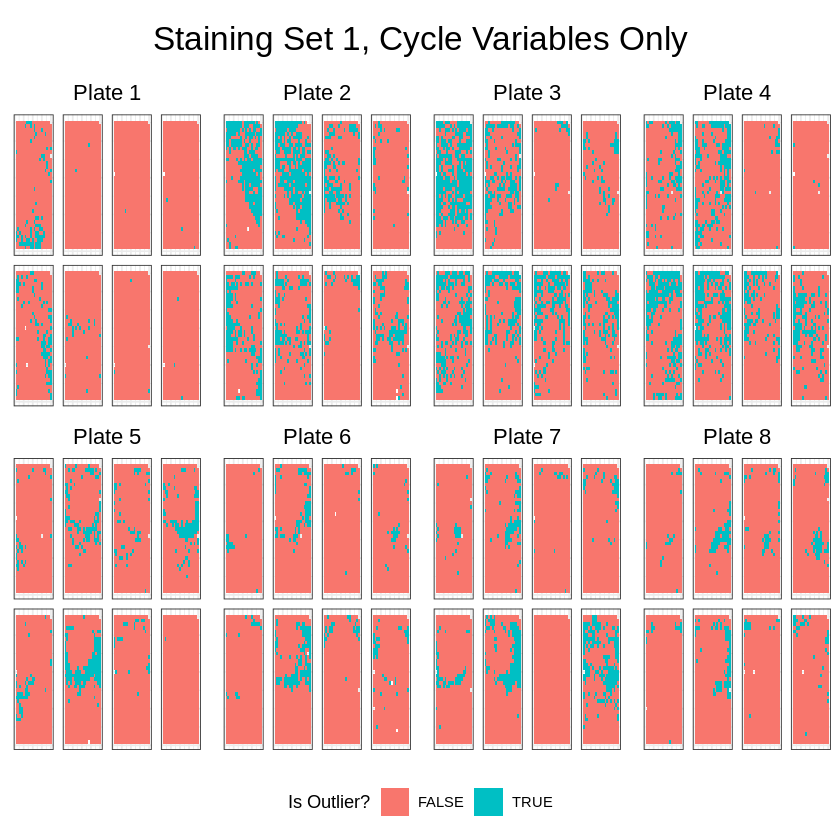

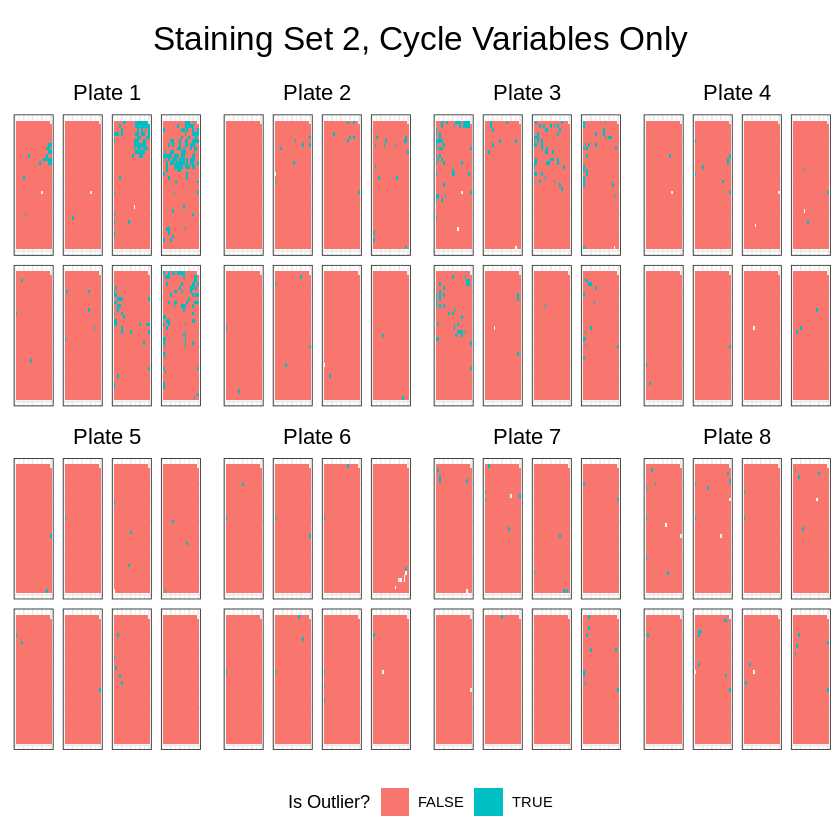

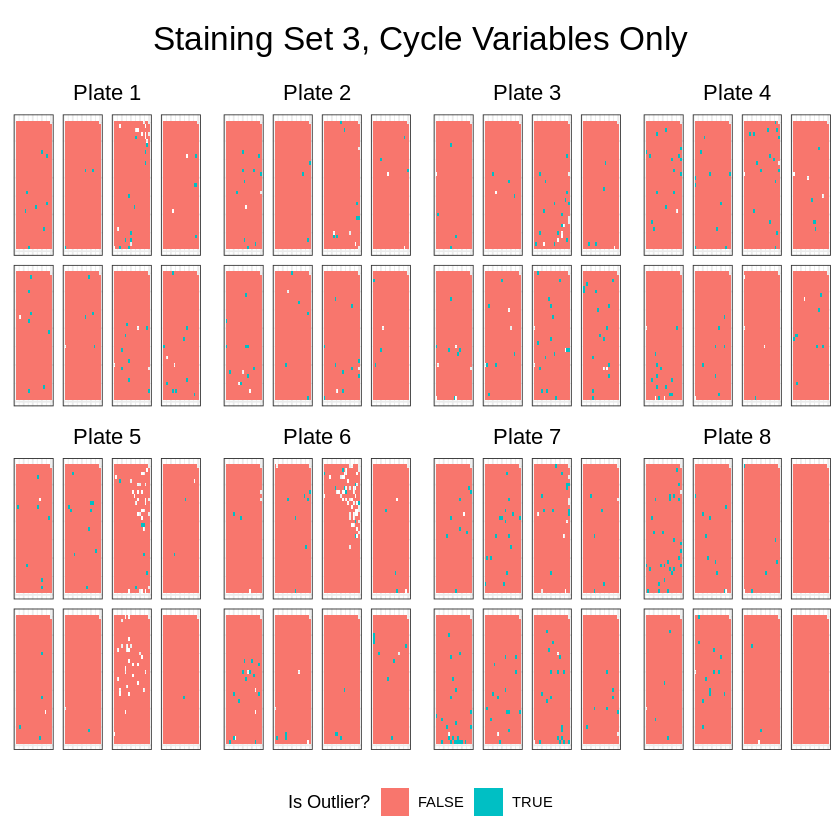

In [81]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Cycle", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

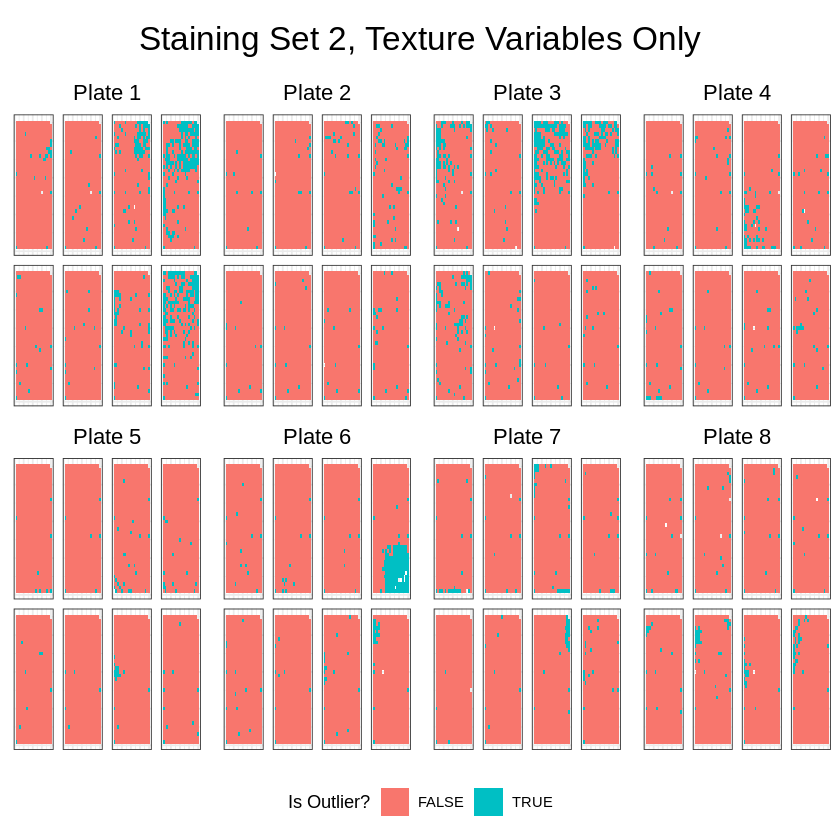

In [84]:
all_data2 %>%
  filter(ss_num == 2) %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Texture", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

### Outlier Detection by Cell Part

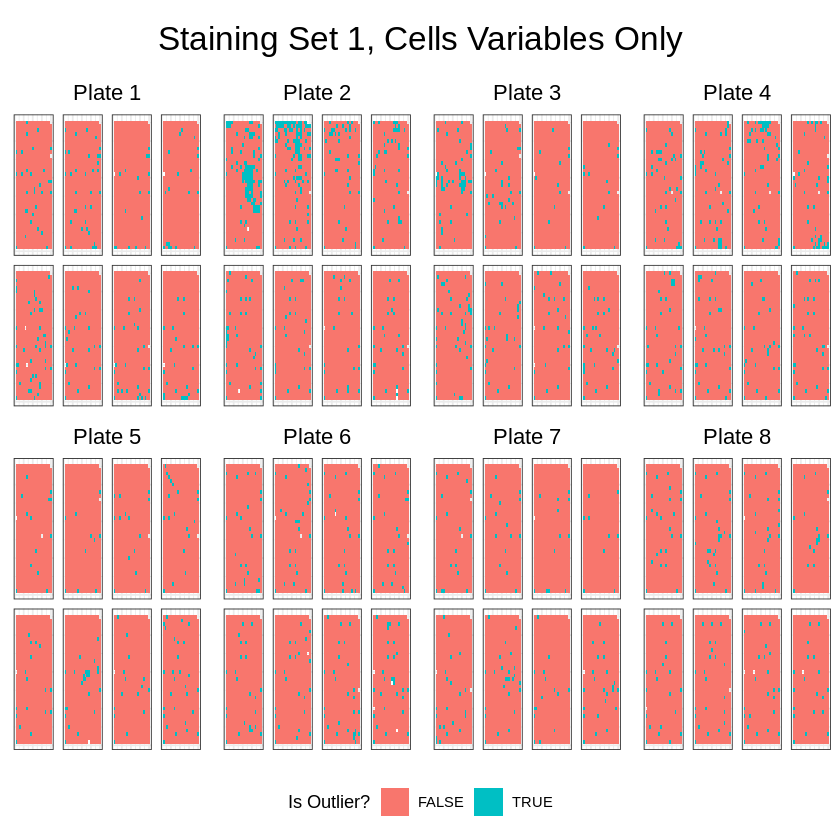

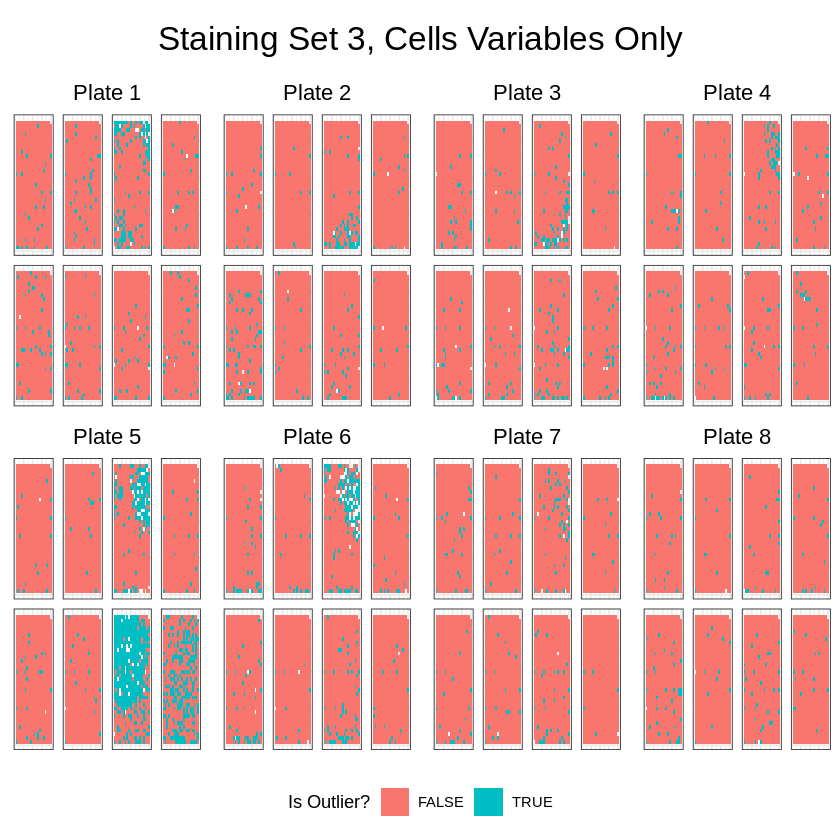

In [85]:
all_data2 %>%
  filter(ss_num %in% c(1, 3)) %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Cells", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

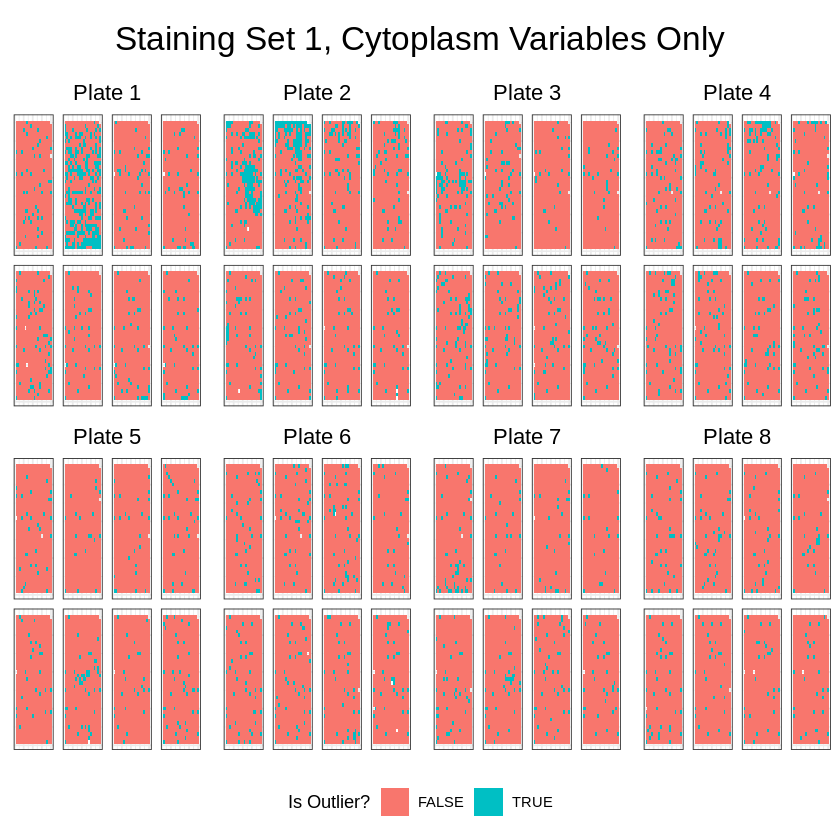

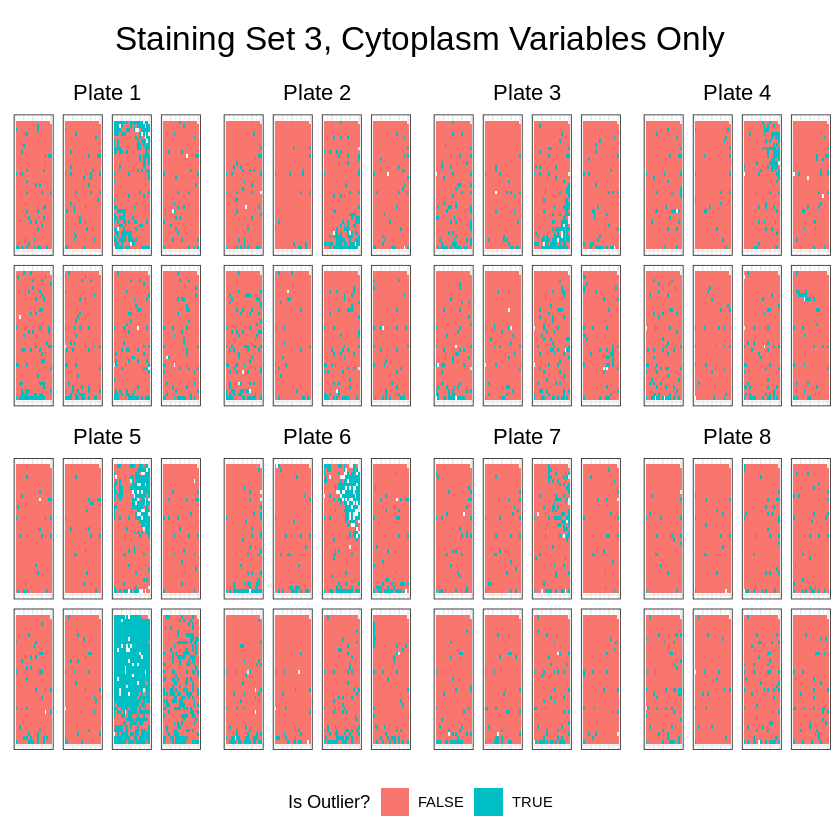

In [86]:
all_data2 %>%
  filter(ss_num %in% c(1, 3)) %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Cytoplasm", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))

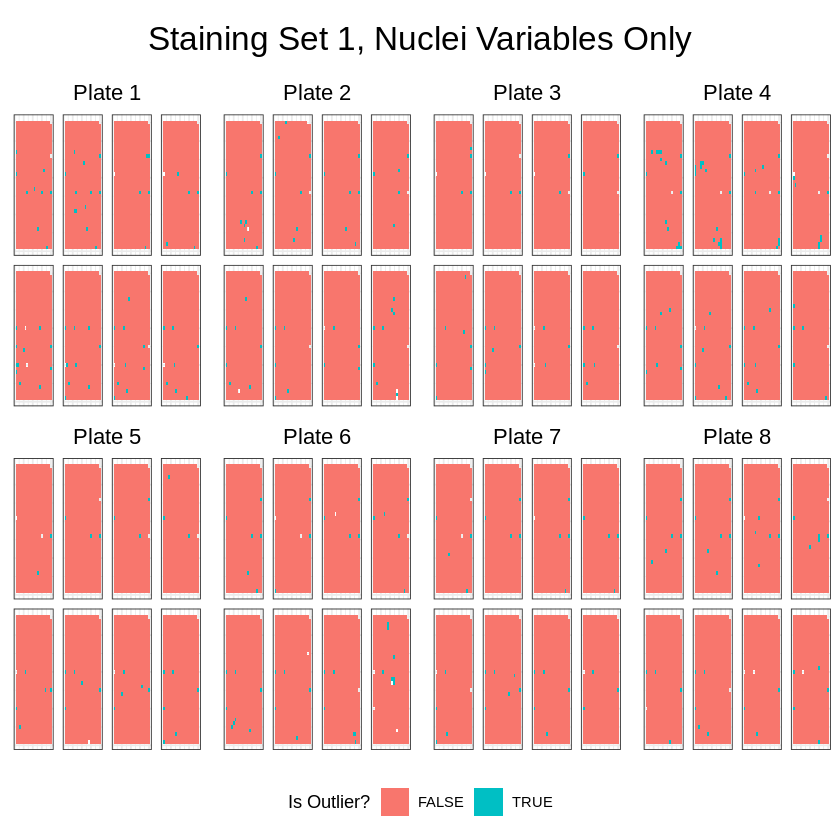

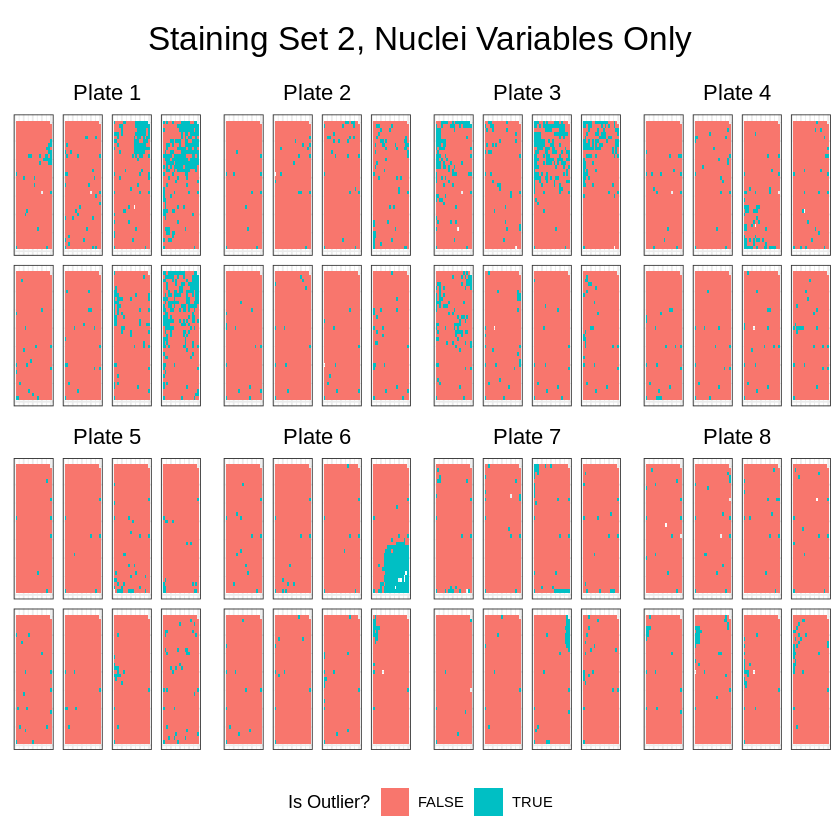

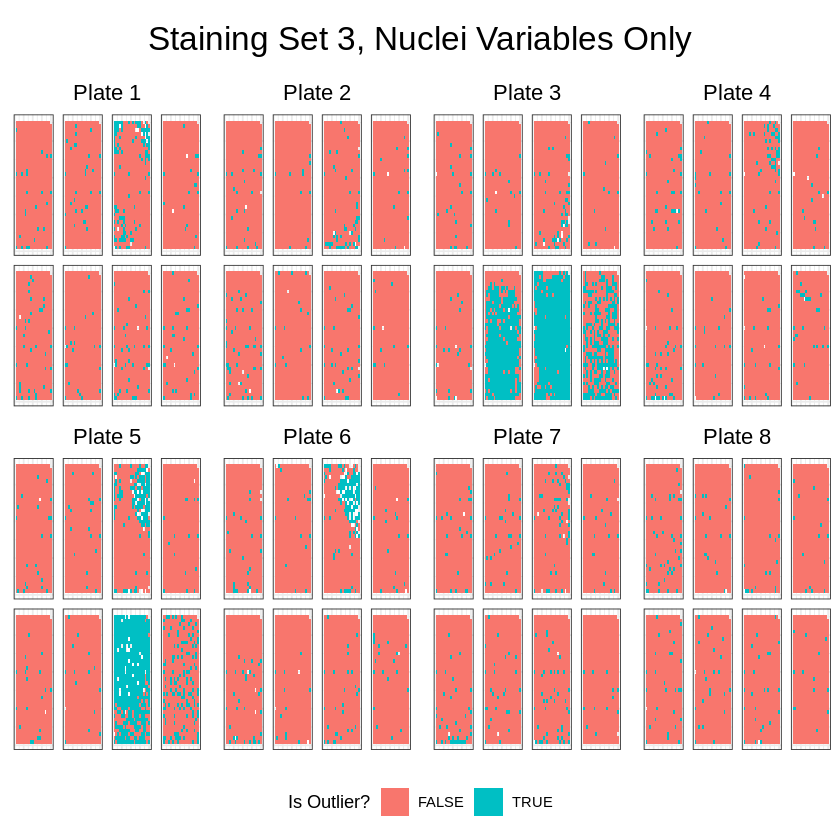

In [87]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "Nuclei", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))